In [1]:
import torch
# from qer.ai.hemorrhages import Hemorrhages2DBlend
import pandas as pd
from monai.data import Dataset
from torch.utils.data import DataLoader
import monai
import random
from typing import Any, Dict, List, Sequence, Union, Tuple, Optional

import numpy as np
import SimpleITK as sitk
import torch
import time
from loguru import logger
from monai.transforms import (
    DivisiblePadd,
    RandomizableTransform,
    Transform,
    Resize
)
from torch.nn.functional import interpolate
from skimage.transform import rescale
from pydicom import dcmread
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import torch.nn.functional as F
import h5py
from tqdm.auto import tqdm
from scipy import ndimage as ndi
import os
import torch
from qer.utils.db import get_mongo_db
db = get_mongo_db()
from qer.utils.imageoperations.resampler import load_raw_sitk_img
from monai.data import Dataset
import copy
import skimage.segmentation as skimg_segm
import sqlite3
from qer.ai.predictor.get_predictions import load_and_run_model
from skimage.morphology import skeletonize
from skimage.filters import median

Unable to find logging config yaml. Configuring fallback values
[2023-11-02 13:55:51 +0530] [WARNING] Invalid or unsupported selector 'select:not(:has(option[selected])) option:first-of-type,
option[selected]:not(option[selected] ~ option[selected]) ', ('Unknown pseudo-class', 'has')


In [2]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import widgets
from ipywidgets import interact


def plot_scans(img_arr_list, title_list):
    cols = len(img_arr_list)
    num_slices = img_arr_list[0].shape[0]

    def callback(z=None):
        fig, ax = plt.subplots(1, cols, figsize=(5*cols, 5*cols), squeeze=False)
        for idx in range(cols):
            ax[0][idx].imshow(img_arr_list[idx][z, :, :], cmap='gray')
            ax[0][idx].title.set_text(title_list[idx])
            ax[0][idx].axis('off')
            ax[0][idx].grid(False)

        fig.tight_layout()
        fig.show()

    interact(
        callback,
        z=widgets.IntSlider(value=0, min=0, max=(num_slices - 1), step=1)
    )

In [3]:
def draw_mask_boundary(image: np.ndarray, label_img: np.ndarray, color=(1, 1, 0)):
    image = copy.deepcopy(image)
    label_img = label_img.astype(np.uint8)
    image = (image - image.min()) / (image.max() - image.min())
    if len(image.shape) == 2:
        return skimg_segm.mark_boundaries(
            image,
            label_img,
            color=color,
            outline_color=None,
            mode="outer",
            background_label=0,
        )
    elif len(image.shape) == 3:
        imgs = []
        for idx in range(label_img.shape[0]):
            if label_img[idx].sum() != 0:
                imgs.append(draw_mask_boundary(image[idx], label_img[idx]))
                # imgs.append(np.stack([image[idx]] * 3, axis=2))
            else:
                imgs.append(np.stack([image[idx]] * 3, axis=2))
        return np.stack(imgs, axis=0)
    else:
        raise NotImplementedError(f"Only 3d or 2d images are supported., Given {image.shape}")


In [4]:
from qer.utils.preprocessing.windowing import window_generator
brain_window = window_generator(80 , 40)
blood_window = window_generator(175 , 50)
bone_window = window_generator(3000 , 500)
cta_window = window_generator(600,300)

In [1]:
import pyrootutils
import hydra

root = pyrootutils.setup_root(search_from="./", indicator=[".git", "pyproject.toml"], pythonpath=True, dotenv=True)


In [2]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
hydra.initialize("../configs/datamodule/", version_base="1.2")
data_module = hydra.compose("bleed_seg_test.yaml")

In [3]:
datamodule = hydra.utils.instantiate(data_module)

InstantiationException: Error locating target 'src.datamodules.base_dataloader.MetaClsDataModule', see chained exception above.

In [57]:
df_train = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/ICH_analyis_train.csv")
df_train[(df_train["threshold"] == 0.5) & (df_train["dice_score"] == 0)]

,StudyUID,Dataset,threshold,dice_score,pred_volume,abs_vol_error,dice_score_pp,pred_volume_pp,abs_vol_error_pp,dice_score_pp_no_dilation,pred_volume_pp_no_dilation,abs_vol_error_pp_no_dilation
351,1.2.840.113619.2.278.3.2831165736.316.13586271...,train,0.5,0.0,0.197887,0.596046,0.000000,1.541375,0.747441,0.0,0.197887,0.596046
427,1.2.840.113619.2.278.3.2831165748.949.13619138...,train,0.5,0.0,0.000000,1.465051,0.000000,0.000000,1.465051,0.0,0.000000,1.465051
446,1.2.840.113619.2.81.290.1.2896.20130815.213653,train,0.5,0.0,0.535250,0.798702,0.000000,2.244710,0.910759,0.0,0.520944,0.813007
655,1.2.840.113619.2.278.3.2831165736.312.13517400...,train,0.5,0.0,0.000000,1.975296,0.000000,0.000000,1.975296,0.0,0.000000,1.975296
997,1.2.840.113619.2.81.290.1.185.20130511.223256,train,0.5,0.0,0.524521,2.534389,0.000000,1.220703,1.838207,0.0,0.460148,2.598762
...,...,...,...,...,...,...,...,...,...,...,...,...
27787,1.2.840.113619.2.278.3.2831165748.894.13629714...,train,0.5,0.0,0.020355,2.961185,0.000000,0.276406,2.705134,0.0,0.019284,2.962256
27863,1.2.840.113619.2.278.3.2831165735.303.13348023...,train,0.5,0.0,0.321865,14.080987,0.004565,2.311466,12.091386,0.0,0.319481,14.083371
27882,1.3.6.1.4.1.25403.52240747607.2744.20150518060...,train,0.5,0.0,0.000000,0.089237,0.000000,0.000000,0.089237,0.0,0.000000,0.089237
28243,1.2.840.113619.2.278.3.2831165736.236.13543298...,train,0.5,0.0,0.000000,3.908869,0.000000,0.000000,3.908869,0.0,0.000000,3.908869


In [59]:
df_train[(df_train["threshold"] == 0.4) & (df_train["dice_score"] == 0)]

,StudyUID,Dataset,threshold,dice_score,pred_volume,abs_vol_error,dice_score_pp,pred_volume_pp,abs_vol_error_pp,dice_score_pp_no_dilation,pred_volume_pp_no_dilation,abs_vol_error_pp_no_dilation
444,1.2.840.113619.2.81.290.1.2896.20130815.213653,train,0.4,0.0,5636.272468,5634.938517,0.000000,32.424920,31.090968,0.0,6.815194,5.481242
653,1.2.840.113619.2.278.3.2831165736.312.13517400...,train,0.4,0.0,6348.130163,6346.154867,0.000000,33.252205,31.276909,0.0,29.023856,27.048560
1204,1.2.840.113619.2.81.290.1.3193.20140923.203141,train,0.4,0.0,7749.787174,7749.546371,0.000000,47.861328,47.620525,0.0,17.318722,17.077919
1356,1.2.840.113619.2.81.290.9163.3191.20130606.290935,train,0.4,0.0,5532.918035,5528.256953,0.000652,13.622043,8.960960,0.0,8.301733,3.640651
1451,1.2.840.113619.2.81.290.1.1361.20140329.292857,train,0.4,0.0,5851.639503,5851.606124,0.000000,12.048480,12.015102,0.0,9.386538,9.353159
...,...,...,...,...,...,...,...,...,...,...,...,...
25942,1.2.840.113619.2.278.3.2831165748.860.13629006...,train,0.4,0.0,5479.113213,5478.837840,0.000000,25.868389,25.593016,0.0,15.517457,15.242084
26303,1.2.840.113619.2.55.3.2831165748.839.143281845...,train,0.4,0.0,3829.551636,3824.627563,0.000000,10.095337,5.171265,0.0,7.895874,2.971802
26588,1.2.840.113619.2.278.3.2831165748.239.13611637...,train,0.4,0.0,2788.364073,2787.806102,0.000000,9.384603,8.826632,0.0,6.159875,5.601904
27785,1.2.840.113619.2.278.3.2831165748.894.13629714...,train,0.4,0.0,5052.107018,5049.125478,0.000000,15.324453,12.342913,0.0,13.077852,10.096312


In [9]:
train_ds = datamodule.train_ds
val_ds = datamodule.val_ds
test_ds = datamodule.test_ds

In [10]:
from src.common.nn_modules.nets.segmentation.multitaskfusion import MultiTaskFusionNet , modify_model_state_dict

In [83]:
from typing import Any, Dict, List, Optional, Literal

import numpy as np
import torch
from torch import Tensor
from torchmetrics import Metric
from loguru import logger
from monai.networks import one_hot

class Dice3D(Metric):
    dice_scores: List[Tensor]
    full_state_update: bool = True

    def __init__(
        self,
        num_classes: int,
        conf_thresholds: List[float] = [0.5],
        compute_on_step: Optional[bool] = None,
        ignore_background: bool = False,
        average: Optional[Literal["micro", "macro", "weighted", "none"]] = "micro",
        **kwargs: Dict[str, Any]
    ):
        """_summary_

        Args:
            conf_thresholds (Optional[List[float]], optional): _description_. Defaults to None.
            compute_on_step (Optional[bool], optional): _description_. Defaults to None.
            ignore_background (bool): ignore dice computation for background pixels

        Example:
        ```
        import torch
        pred = [torch.ones(2, 3, 3, 3)]
        gt = [torch.cat([torch.zeros(1, 3, 3, 3), torch.ones(1, 3, 3, 3)], dim=0)]
        dice_mat = Dice3D(ignore_background=False)
        dice_mat.update(preds=pred, target=gt)
        print(dice_mat.compute())
        ```
        """
        super().__init__(compute_on_step=compute_on_step, **kwargs)
        self.num_classes = num_classes
        self.conf_thresholds = conf_thresholds
        self.ignore_background = ignore_background
        self.average = average
        self.add_state("dice_scores", default=[], dist_reduce_fx=None)

    def update(self, preds: List[Dict[str, Tensor]], target: List[Dict[str, Tensor]]) -> None:  # type: ignore
        """Add detections and ground truth to the metric.
        Args:
            preds: A list consisting of Tensors. Each Tensor are prediction corresponding to one image.
            - Each probability Tensor should be in following format [num_class, z, y, x]
            - Each probability Tensors value range should be in [0, 1]
            target: A list consisting of tensors, Each Tensor are prediction corresponding to one image.
            - Each Tensor should be in following format [num_class, z, y, x]
            - values should be either 1 or 0
        """
        # _input_validator(preds, target, self.num_classes)

        if target[-1].shape[0] == 1 :
            target = one_hot(target,self.num_classes)
            
        assert target.shape == preds.shape

        self.input_device = preds.device
        self.dice_scores.append(self._get_intermediate_dice(preds, target))

    def _get_intermediate_dice(
        self, preds: List[Dict[str, Tensor]], target: List[Dict[str, Tensor]]
    ):
        nb_classes = len(self._get_classes())
        nb_confs = len(self.conf_thresholds)
        nb_imgs = len(preds)
        dice_score = -1 * torch.ones(nb_imgs, nb_classes, nb_confs).to(self.input_device)
        iou_score = -1 * torch.ones(nb_imgs, nb_classes, nb_confs).to(self.input_device)

        # logger.debug(f"nb_classes: {nb_classes}, nb_confs: {nb_confs}, nb_imgs: {nb_imgs}")
        # logger.debug(f"dice_score: {dice_score.shape}, iou_score: {iou_score.shape}")
        
        for idx_cls in range(nb_classes):
            if self.ignore_background and idx_cls == 0:
                continue
            for idx_conf in range(nb_confs):
                dice_score, iou_score = self._calculate_dice_score(
                    dice_score=dice_score,
                    iou_score=iou_score,
                    class_idx=idx_cls,
                    conf_idx=idx_conf,
                    pred_probs=preds,
                    gt_labels=target,
                )
        return dice_score

    def _get_classes(self):
        if self.num_classes is not None:
            return np.arange(self.num_classes)
        return []

    @staticmethod
    def __compute_dice(pred_mask, gt_mask):
        """
        Compute dice score given two binary mask
        dice score = 2*area(inter(pred_mask, gt_mask)) / area(gt_mask) + area(pred_mask)
        """
        return (2 * torch.sum(pred_mask * gt_mask)) / (torch.sum(pred_mask) + torch.sum(gt_mask))

    @staticmethod
    def __compute_iou(pred_mask, gt_mask):
        """Compute IoU of the predicted binary mask and ground truth mask."""

        return torch.sum(pred_mask * gt_mask) / torch.sum(torch.logical_or(pred_mask, gt_mask))

    def _calculate_dice_score(
        self,
        dice_score,
        iou_score,
        class_idx,
        conf_idx,
        pred_probs: List[Tensor],
        gt_labels: List[Tensor],
    ):
        for index, (detection_prob, gt_mask) in enumerate(zip(pred_probs, gt_labels)):
            det_binary = detection_prob[class_idx] >= self.conf_thresholds[conf_idx]
            gt_binary = gt_mask[class_idx]
            dice_score[index, class_idx, conf_idx] = self.__compute_dice(det_binary, gt_binary)
            iou_score[index, class_idx, conf_idx] = self.__compute_iou(det_binary, gt_binary)

        return dice_score, iou_score

    def compute(self):
        if self.dice_scores == []:
            return None
        dice_scores = torch.cat(self.dice_scores, dim=0)
        if self.average == "micro":
            return dice_scores[(dice_scores >= 0) & (~dice_scores.isnan())].mean()
        elif self.average == "macro":
            return (torch.mean(dice_scores , 0)).mean()
        elif self.average in ['none' , None] :
            return torch.mean(dice_scores , 0)[:,0]

In [11]:
os.listdir("/data_nas5/qer/shubham/ich_checkpoints/ich_segmentation/runs/2023-09-21_01-27-48/checkpoints/")

['epoch=68_step=1000_val_loss=0.76.ckpt',
 'epoch=66_step=956_val_loss=0.75.ckpt',
 'last.ckpt']

In [11]:
# ckpt_path = "/data_nas5/qer/shubham/ich_checkpoints/ich_segmentation/runs/2023-09-23_20-20-59/checkpoints/epoch=155_step=3744_val_loss=8.24.ckpt"

# ckpt_path = "/data_nas5/qer/shubham/ich_checkpoints/ich_segmentation/runs/2023-09-24_19-17-49/checkpoints/epoch=5_step=132_val_loss=0.51.ckpt"
# ckpt_path = "/data_nas5/qer/shubham/ich_checkpoints/ich_segmentation/runs/2023-09-25_23-46-37/checkpoints/epoch=194_step=4680_val_loss=0.42.ckpt"
# # ckpt_path = "/data_nas5/qer/shubham/ich_checkpoints/ich_segmentation/runs/2023-09-26_19-10-42/checkpoints/epoch=198_step=4776_val_loss=58.14.ckpt"
# ckpt_path = "/data_nas5/qer/shubham/ich_checkpoints/ich_segmentation/runs/2023-09-26_23-07-16/checkpoints/epoch=214_step=5160_val_loss=5.25.ckpt"

# ckpt_path = "/data_nas5/qer/shubham/ich_checkpoints/ich_segmentation/runs/2023-09-27_11-34-11/checkpoints/epoch=218_step=5256_val_loss=0.78.ckpt"

ckpt_path = "/data_nas5/qer/shubham/ich_checkpoints/ich_segmentation/runs/2023-09-27_14-06-10/checkpoints/epoch=226_step=5448_val_loss=10.60.ckpt"

# ckpt_path = "/data_nas5/qer/shubham/ich_checkpoints/ich_segmentation/runs/2023-09-27_17-29-33/checkpoints/epoch=229_step=5520_val_loss=0.44.ckpt"

k= torch.load(ckpt_path, map_location = "cpu")
state_dict = k['state_dict']
new_state_dict = modify_model_state_dict(state_dict , "net." , "")



In [12]:
new_state_dict

{'teacher_backbone.encoder.conv1.weight': tensor([[[[ 7.3336e-02,  5.0804e-02,  5.6922e-02,  ...,  3.4823e-02,
            -4.3687e-03,  4.7938e-02],
           [-1.3838e-02,  3.3024e-02, -2.2854e-02,  ..., -6.8162e-03,
             7.8002e-02,  3.3519e-02],
           [ 4.7061e-02, -7.3903e-02, -1.0275e-01,  ..., -9.6805e-02,
             5.7728e-02,  3.0030e-03],
           ...,
           [ 3.7302e-02,  1.6848e-02, -1.4351e-01,  ...,  2.8022e-03,
             1.4440e-01,  1.0960e-01],
           [ 5.3217e-02,  3.0133e-02, -8.8829e-02,  ...,  9.2273e-03,
             9.0010e-02,  4.1249e-02],
           [ 9.8711e-02,  8.9524e-02,  1.4852e-02,  ...,  1.1092e-01,
             1.1774e-01, -2.0465e-02]],
 
          [[-1.0143e-01, -4.2375e-02, -1.1848e-01,  ..., -3.0617e-01,
            -1.3123e-01, -5.0167e-02],
           [-1.2911e-01,  2.6989e-02,  4.9955e-03,  ..., -2.9573e-03,
            -8.0662e-02, -1.0802e-01],
           [-1.1333e-01,  6.9727e-02,  2.5076e-01,  ...,  2.7033e-01

In [13]:
model =  MultiTaskFusionNet()
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [14]:
!nvidia-smi


Thu Sep 28 15:18:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 33%   31C    P8    24W / 350W |      8MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:41:00.0 Off |                  N/A |
| 33%   

In [15]:
model = model.to("cuda:1")
model.eval()


MultiTaskFusionNet(
  (teacher_backbone): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

In [16]:
activation = torch.nn.Softmax(dim=1)

In [50]:
i = 1
# data = test_ds[i]
data = train_ds[i]

In [15]:
icv_mask = data["icv_mask"]
falx = data["falx"]

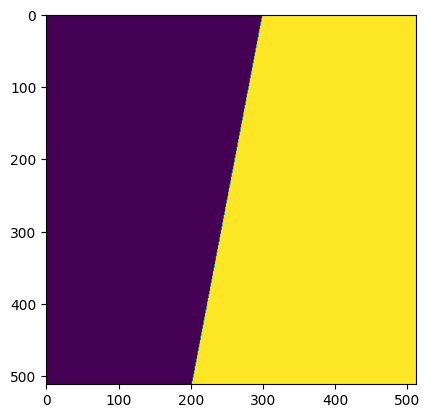

In [26]:
plt.imshow(data["hemi_seperator_mask"])
plt.show()

In [37]:
import cv2
edge_mask = cv2.Canny(data["hemi_seperator_mask"].astype(np.uint8), 0, 1)  # Using Canny edge detection
kernel_size = 15  # Adjust this to control the thickness of the edges
dilated_edge_mask = cv2.dilate(edge_mask, np.ones((kernel_size, kernel_size), np.uint8))

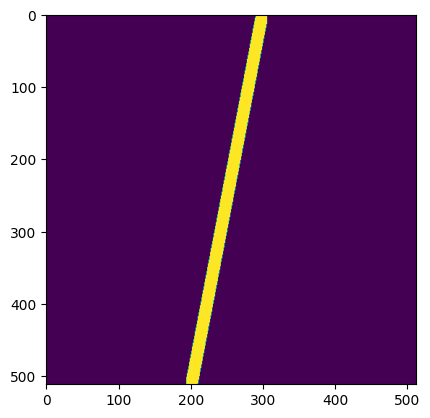

In [38]:
plt.imshow(dilated_edge_mask)
plt.show()

In [16]:
plot_scans([icv_mask.squeeze(0) , falx.squeeze(0)],["icv_mask","falx"])

interactive(children=(IntSlider(value=0, description='z', max=31), Output()), _dom_classes=('widget-interact',…

In [40]:
f2 = h5py.File(data['datapath'] , "r")

In [41]:
f2.keys()

<KeysViewHDF5 ['image', 'mask']>

In [51]:
k = []
for i in range(len(train_ds)) :
    data = train_ds[i]
    gt = data['mask'].squeeze(0).numpy()
    if np.max(gt) == 0 :
        print(i)
        k.append(data["study_uid"])


0
1
3
4
5
9
16
21
31
34
35
41
45
47
49
52
55
58
60
71
72
73
83
87
97
100
102
108
110
111
119


In [52]:
# data = test_ds[i]
for i in range(len(train_ds)) :
    data = train_ds[i]
    if data["study_uid"] not in k :
        print(i)
    

2
6
7
8
10
11
12
13
14
15
17
18
19
20
22
23
24
25
26
27
28
29
30
32
33
36
37
38
39
40
42
43
44
46
48
50
51
53
54
56
57
59
61
62
63
64
65
66
67
68
69
70
74
75
76
77
78
79
80
81
82
84
85
86
88
89
90
91
92
93
94
95
96
98
99
101
103
104
105
106
107
109
112
113
114
115
116
117
118
120


In [21]:
i = 1
data = train_ds[i]

In [22]:
image = data['image'].unsqueeze(0).to("cuda:1")
model_outputs = model(image)
soft_out = activation(model_outputs["student_mask"]).squeeze(0).detach().cpu().numpy()
soft_out_teach = activation(model_outputs["teacher_mask"]).squeeze(0).detach().cpu().numpy()

gt = data['mask'].squeeze(0).numpy()

In [23]:
for i in range(gt.shape[0]):
    if np.max(gt[i]) == 1 :
        print(i)

17


In [24]:
plot_scans([image.squeeze(0)[0].cpu().numpy() , data['mask'].squeeze(0).numpy(),soft_out[1]>=0.3,soft_out[1],soft_out_teach[1]>0.5] , ["image","gt" , "","",""])


interactive(children=(IntSlider(value=0, description='z', max=31), Output()), _dom_classes=('widget-interact',…

In [58]:
import monai

In [79]:
pred = activation(model_outputs["student_mask"])
labels = data['mask']

In [81]:
pred.shape

torch.Size([1, 2, 32, 224, 224])

In [100]:
dice = Dice3D(num_classes=2,average="micro",ignore_background=True).to("cuda:1")

In [106]:
dice.update(pred, labels.unsqueeze(0).to("cuda:1"))

In [105]:
dice.dice_scores = []

In [107]:
a =dice.compute()

In [114]:
a.item()

0.13793103396892548

In [109]:
dice.dice_scores

[tensor([[[-1.0000],
          [ 0.1379]]], device='cuda:1')]

In [64]:
df_train[df_train["StudyUID"] == data["study_uid"]]

,StudyUID,dsc,sens,spec,teacher_dsc,teacher_sens,teacher_spec
159,1.2.840.10008.1.83815.1840306034.425578308.149...,0.0,0.0,0.999999,0.0,0.0,1.0


In [56]:
import pyrootutils
import hydra
import torch
import pandas as pd
from tqdm.auto import tqdm
from src.common.nn_modules.nets.segmentation.multitaskfusion import (
    MultiTaskFusionNet,
    modify_model_state_dict,
)
from torch.utils.data import DataLoader
from loguru import logger
import numpy as np



def dice_coefficient(mask1, mask2):
    # Ensure that both masks have the same shape
    if mask1.shape != mask2.shape:
        raise ValueError("Input masks must have the same shape.")

    # Calculate the intersection and union of the two masks
    intersection = np.sum(mask1 * mask2)
    union = np.sum(mask1) + np.sum(mask2)

    # Calculate the Dice coefficient
    dice = (2.0 * intersection) / (
        union + 1e-8
    )  # Adding a small epsilon to avoid division by zero

    return dice


def get_sensitivity(mask1, mask2):
    # Calculate True Positives (TP) and False Negatives (FN)
    TP = np.sum((mask1 == 1) & (mask2 == 1))
    FN = np.sum((mask1 == 1) & (mask2 == 0))

    # Calculate sensitivity (True Positive Rate)
    sensitivity = TP / (TP + FN)

    return sensitivity


def get_specificity(mask1, mask2):
    TN = np.sum((mask1 == 0) & (mask2 == 0))
    FP = np.sum((mask1 == 0) & (mask2 == 1))

    # Calculate specificity
    specificity = TN / (TN + FP)

    return specificity

In [57]:
pred = soft_out[1] > 0.5

gt = data["mask"].squeeze().numpy()

dsc = dice_coefficient(gt, pred)
sens = get_sensitivity(gt, pred)
spec = get_specificity(gt, pred)

In [58]:
dsc

0.0

In [19]:
uid = "1.2.840.113711.576442.2.5564.600700436.26.2116281012.182450"

In [25]:
def get_dev_headct_arr(study_uid) : 
    base_path = '/cache/fast_data_nas8/qer/shubham/ich'
    path = os.path.join(base_path, study_uid)
    h5_data = path + '.h5'
    
    if os.path.exists(h5_data) :
        f2 = h5py.File(h5_data, 'r')

        if "mask" not in f2.keys():
            base_path = "/cache/fast_data_nas8/qer/shubham/ich_seg_train_val"
            path = os.path.join(base_path, study_uid)
            h5_data = path + '.h5'
            f2 = h5py.File(h5_data, 'r')
            image = f2['image']
            mask = f2["mask"]
            arr = np.array(image)
            mask = np.array(mask)
            f2.close()
            return arr ,mask
        
        image = f2['image']
        mask = f2["mask"]
        arr = np.array(image)
        mask = np.array(mask)
        f2.close()
        return arr, mask
    else:
        return None
    
def get_fda_spacing(study_uid): 
    rows = df_fda_test[df_fda_test.StudyUID == study_uid]
    if len(rows) > 0 :
        series_uid = rows.iloc[0].SeriesUID
        series_dict = db.dicoms.find_one({'_id' : series_uid })
        ftrs = geometry.get_features(series_dict)
        return (ftrs['delta_x'], ftrs['delta_y'], 5)
    
    
def get_dev_spacing(study_uid): 
    rows = df_hemorrhage_mask[df_hemorrhage_mask.StudyUID == study_uid]
    if len(rows) > 0 :
        series_uid = rows.iloc[0].SeriesUID_x
        series_dict = db.dicoms.find_one({'_id' : series_uid })
        ftrs = geometry.get_features(series_dict)
        return (ftrs['delta_x'], ftrs['delta_y'], 5)


def get_fda_headct_arr(study_uid):
    base_path = '/cache/fast_data_nas8/qer/shubham/ich_seg'
    path = os.path.join(base_path, study_uid)
    h5_data = path + '.h5'
    
    if os.path.exists(h5_data) :
        f2 = h5py.File(h5_data, 'r')
        image = f2['image']
        mask = f2["mask"]
        arr = np.array(image)
        mask = np.array(mask)
        f2.close()
        return arr, mask
    else:
        return None

In [ ]:
1.2.840.113619.2.55.3.2831165733.951.1397502532.227

In [41]:
if os.path.exists(f"/cache/fast_data_nas8/qer/shubham/ICH_analysis/{uid}.h5") : 
    h5f = h5py.File(f"/cache/fast_data_nas8/qer/shubham/ICH_analysis/{uid}.h5" , "r")

    logits = np.array(h5f["logits"])[:,0,:,:]
    logits_out = torch.stack([torch.Tensor(-logits) , torch.Tensor(logits)],dim = 1)

    c = activation(logits_out).numpy()
    pred = c[:,1,:,:]
    mask = pred > 0.5
    arr ,gt_arr = get_fda_headct_arr(uid)
    
    print(arr.shape , gt_arr.shape , logits.shape , mask.shape )
    
    plot_scans([brain_window(arr),gt_arr,logits,mask, logits > 0.3], ["scan","gt","logits","softmax on logits","model pred"])


In [69]:
df_train_inf = pd.read_csv("new_quant_model_trai_inference.csv")

In [70]:
df_train_inf.mean()

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


dsc     0.239446
sens    0.286181
spec    0.999025
dtype: float64

In [71]:
df_train_inf

,StudyUID,dsc,sens,spec
0,1.2.840.113619.2.278.3.2831165733.409.13612452...,0.000000,0.000000,0.999876
1,1.2.840.113619.2.55.3.2831165733.791.141429307...,0.210721,0.162578,0.999584
2,1.2.840.113619.2.55.3.2831165748.69.1385518629...,0.000000,0.000000,0.999979
3,1.2.840.113619.2.55.3.2831165733.20.1400814294...,0.371177,0.529061,0.997929
4,1.2.840.113619.2.55.3.2831165733.776.137653204...,0.428675,0.403270,0.998685
...,...,...,...,...
2746,1.2.840.113619.2.81.290.26072.6562.20130412.31...,0.000000,0.000000,1.000000
2747,1.2.840.113619.2.278.3.2831165752.729.13987513...,0.050808,0.423077,0.999753
2748,1.2.840.113619.2.284.3.2831168021.816.13681538...,0.147493,0.158228,0.999514
2749,1.2.840.10008.1.829781.1190104320.449415822.14...,0.478297,0.830435,0.999294


In [161]:
import numpy as np
import segmentation_models_pytorch as smp
import torch
from segmentation_models_pytorch.base import ClassificationHead
from copy import deepcopy
from segmentation_models_pytorch.base import initialization as init
from loguru import logger


decoder_attention_type="gated_sse"


encoder_name="resnet18"
architecture="Unet"
in_chans = 3
num_classes=2
encoder_depth=5

copy_backbone = getattr(smp, architecture)(
    encoder_name=encoder_name,
    encoder_depth=encoder_depth,
    classes= num_classes,
    encoder_weights= None,
    decoder_attention_type=decoder_attention_type,
)
# self.init()

checkpoint_path = "/home/users/shubham.kumar/projects/qureai/packages/python/qer/resources/checkpoints/hemorrhages_quantification/FDA_approved_mixed_mask.pth"
kwargs = {}
kwargs["map_location"] = "cpu"
checkpoint = torch.load(checkpoint_path, **kwargs)

###################
backbone_checkpoint = deepcopy(checkpoint)
####################


for key in ["win_opt.conv2d.weight", "win_opt.conv2d.bias", "multi_fc.fc_0.weight", "multi_fc.fc_0.bias"]:
    del backbone_checkpoint["model_state_dict"][key]
new_state_dict = modify_model_state_dict(backbone_checkpoint["model_state_dict"], "backbone.encoder" , "encoder")
new_state_dict = modify_model_state_dict(new_state_dict, "backbone.decoder" , "decoder")
new_state_dict = modify_model_state_dict(new_state_dict, "backbone.segmentation_head" , "segmentation_head")

copy_backbone.load_state_dict(new_state_dict)

backbone = copy_backbone


In [162]:
df_hemorrhage_mask = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/final_train_val_bleed_pos_seg_dataset.csv")
df_hemorrhage_mask = df_hemorrhage_mask[df_hemorrhage_mask.POSTOP==0]
df_hemorrhage_mask = df_hemorrhage_mask[df_hemorrhage_mask.Intensity=="acute"]
study_uids_having_bleed_mask = list(set(df_hemorrhage_mask.StudyUID.values))


In [163]:
len(study_uids_having_bleed_mask)

1950

In [ ]:
study_uids_having_bleed_mask

In [164]:
backbone



Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [27]:
di = 0
torch.ones((di,di,di)).unsqueeze(0).unsqueeze(0)


tensor([], size=(1, 1, 0, 0, 0))

In [18]:
f2 = h5py.File("/cache/fast_data_nas8/qer/shubham/ich_seg_train_val/1.2.840.113619.2.278.3.2831165736.23.1350263101.478.h5","r")



In [20]:
f2["icv_mask"]

<HDF5 dataset "icv_mask": shape (36, 512, 512), type "<i2">

In [23]:
f2.close()

interactive(children=(IntSlider(value=0, description='z', max=35), Output()), _dom_classes=('widget-interact',…

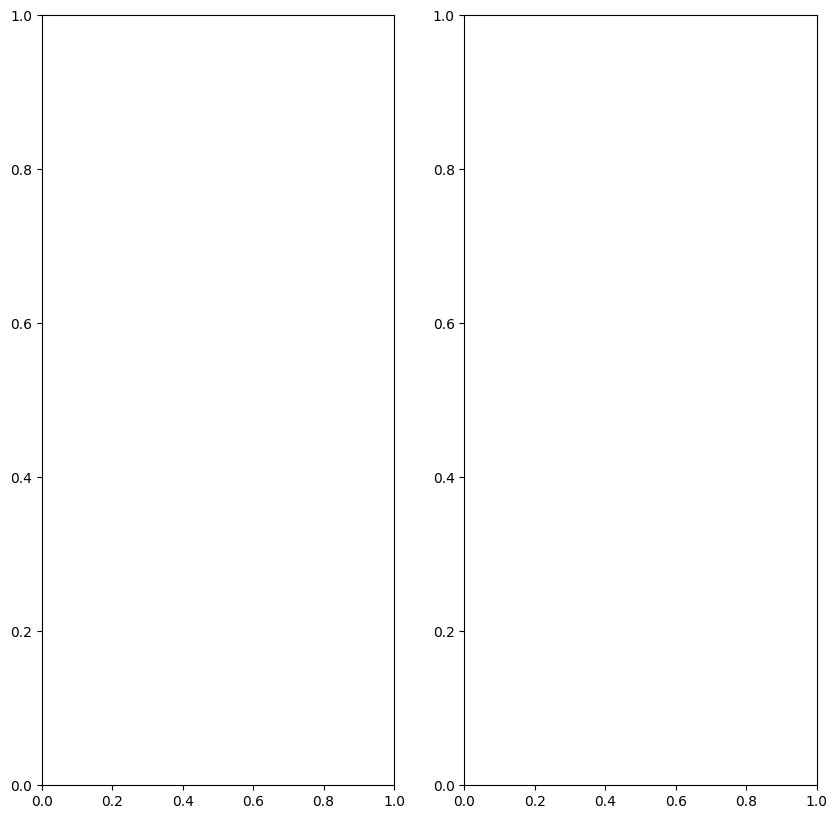

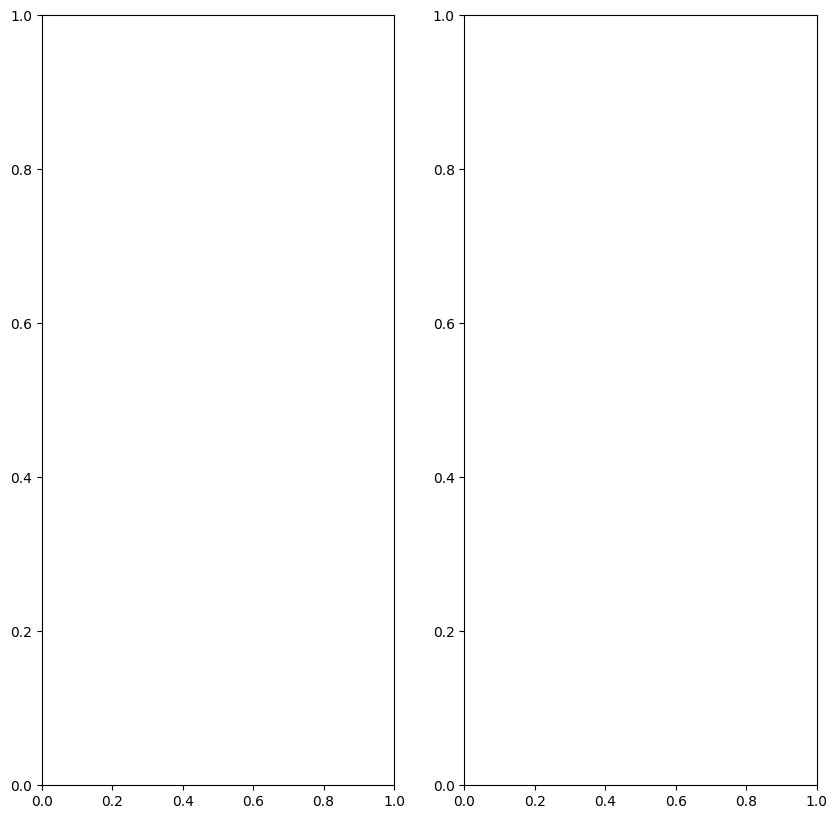

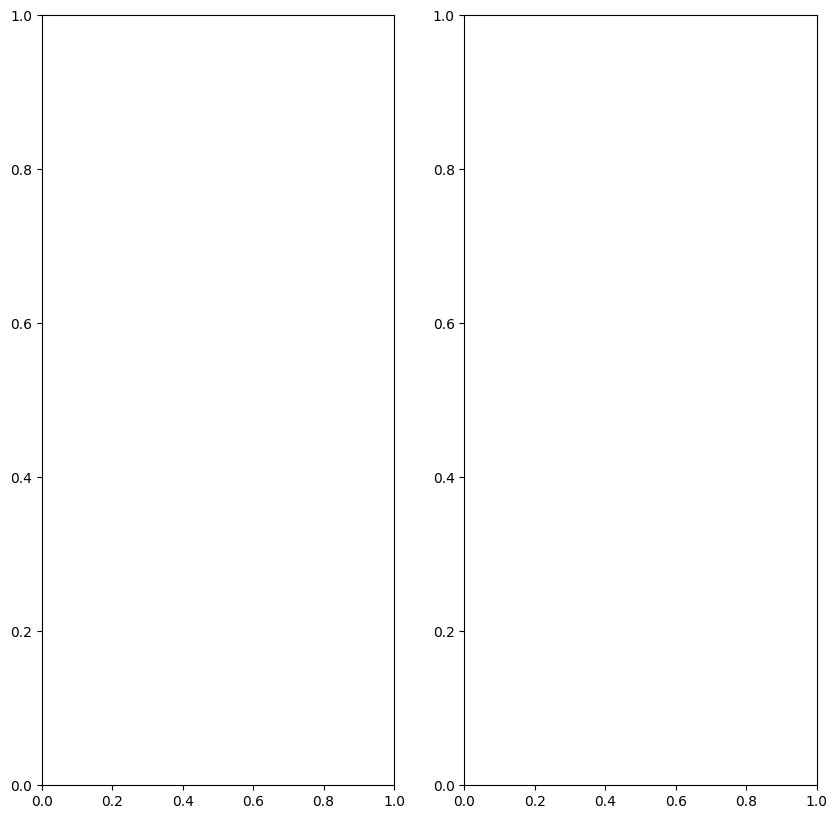

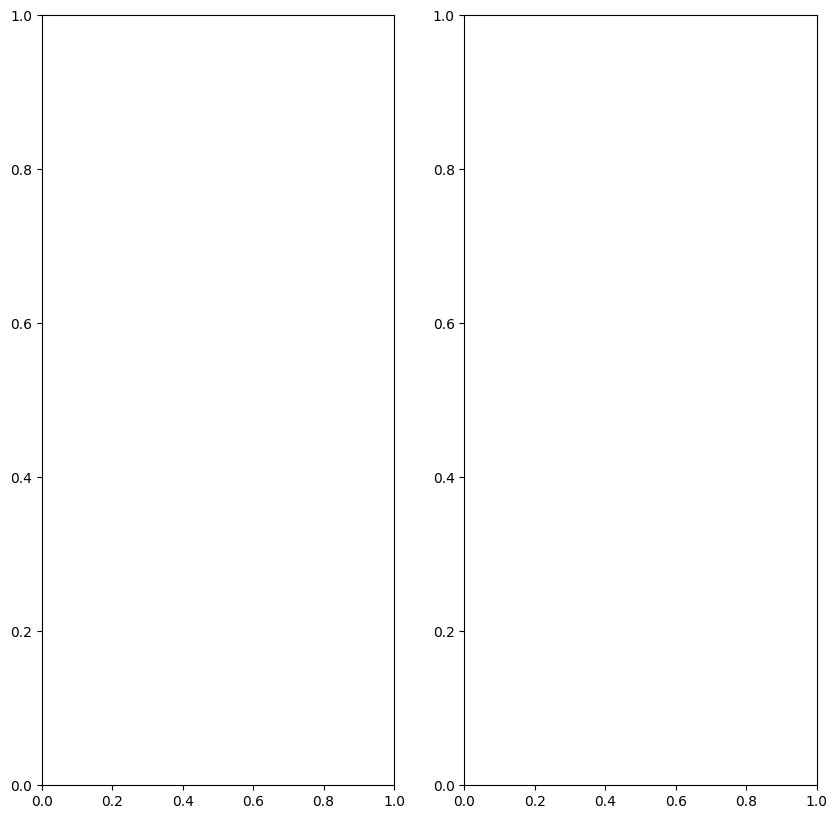

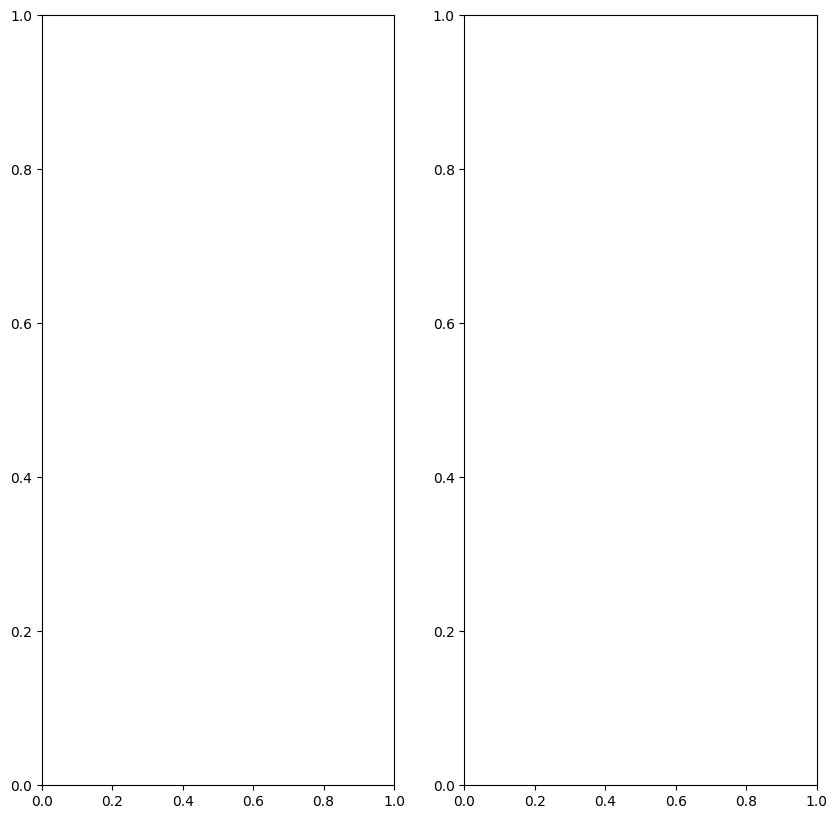

In [22]:
plot_scans([f2["image"], f2["icv_mask"]],["",""])

In [ ]:
from typing import Optional, List, Dict
import numpy as np
import pandas as pd
import os
import os
import ast
from tqdm.auto import tqdm
import h5py
from loguru import logger
import random
import SimpleITK as sitk
from qer.ai.predictor.get_predictions import load_and_run_model 


root_dir = "/data_nas3/processed/hct/Cache/all_imgs_cache.dcm/"

df_hemorrhage_mask = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/final_train_val_bleed_pos_seg_dataset.csv")
df_hemorrhage_mask = df_hemorrhage_mask[df_hemorrhage_mask.POSTOP==0]
df_hemorrhage_mask = df_hemorrhage_mask[df_hemorrhage_mask.Intensity=="acute"]
study_uids_having_bleed_mask = list(set(df_hemorrhage_mask.StudyUID.values))

df_bleed_seg_bbox = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/bleed_seg_bbox.csv")
df_normal = pd.read_csv("/home/users/shubham.kumar/projects/qct_training_framework/notebooks/train_normal_ncct.csv")
normal_study_uids = list(df_normal.sample(5000,random_state=85).StudyUID.values)


df_train = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/ICH_dataset_train.csv")
df_train = df_train[df_train["StudyUID"].isin(study_uids_having_bleed_mask)]

def get_mls_icv(sitk_img):
    output = load_and_run_model("mls_helper_icv_quant",sitk_img)
    icv_mask = output['results']['heatmaps']['ICV']
    icv_mask_arr = sitk.GetArrayFromImage(icv_mask)
#     midline_output = load_and_run_model("mls_quantification" ,sitk_img)
#     mls_arr = sitk.GetArrayFromImage(midline_output['results']['heatmaps']['MLS'])
#     return mls_arr , icv_mask_arr
    return icv_mask_arr

def _load_cls_data(df: pd.DataFrame, phase: str):
    data_dict = []

    for ind, row in tqdm(df.iterrows()):
        temp_dict = {}
        if phase == "test":
            base_path = "/cache/fast_data_nas8/qer/shubham/ich_seg"
            path = os.path.join(base_path, row["StudyUID"])
            temp_dict["datapath"] = path + ".h5"
            temp_dict["study_uid"] = row["StudyUID"]
        else:
            if row["ANY"] == 100:
                continue
            temp_dict["scan_label"] = row["ANY"]
            temp_dict["study_uid"] = row["StudyUID"]
            temp_dict["IPH"] = row["ICH"] or row["CONT"]
            temp_dict["SDH"] = row["SDH"]
            temp_dict["SAH"] = row["SAH"]
            temp_dict["EDH"] = row["EDH"]
            temp_dict["IVH"] = row["IVH"]
            base_path = "/cache/fast_data_nas8/qer/shubham/ich"
            path = os.path.join(base_path, row["StudyUID"])
            temp_dict["datapath"] = path + ".h5"
            if temp_dict["scan_label"] == 1 and temp_dict["study_uid"] in study_uids_having_bleed_mask: 
                try : 
                    f2 = h5py.File(temp_dict["datapath"], "r")
                    if phase == "train" :
                        if "icv_mask" in f2.keys():
                            # logger.debug(temp_dict["datapath"])
                            continue 
                    if "mask" not in f2.keys():
                        base_path = "/cache/fast_data_nas8/qer/shubham/ich_seg_train_val"
                        path = os.path.join(base_path, row["StudyUID"])
                        temp_dict["datapath"] = path + ".h5"
                        f3 = h5py.File(temp_dict["datapath"], "r")
                        if phase == "train" :
                            if "icv_mask" in f3.keys():
                                continue
                            else :
                                logger.debug(temp_dict["datapath"])
                        f3.close

                    f2.close()
                except Exception as e:
                    logger.debug(temp_dict["datapath"])
                    logger.debug(e)
                    continue

            if row["StudyUID"] in normal_study_uids :
                base_path = "/cache/fast_data_nas8/qer/shubham/new_test"
                valid_paths = []
                study_uid =  row["StudyUID"]
                for perp_dist in range(0,30) : 
                    path = os.path.join(base_path, f"{study_uid}_{perp_dist}.h5" )
                    if os.path.exists(path) :
                        valid_paths.append(path)
                if len(valid_paths) > 0 : 
                    temp_dict["datapath"] = random.choice(valid_paths)
                    temp_dict["SDH"] = row["SDH"]
                    temp_dict["scan_label"] = 1
                else :
                    continue
            try:
                temp_dict["crop"] = np.array(ast.literal_eval(row["crop"]))
            except:
                temp_dict["crop"] = None

        if os.path.exists(temp_dict["datapath"]):
            if temp_dict["datapath"] in ["/cache/fast_data_nas8/qer/shubham/ich/1.2.840.113619.2.55.3.2831165742.939.1462502069.683.h5",
                                         "/cache/fast_data_nas8/qer/shubham/ich/1.2.840.113619.2.81.290.1.930.20140413.223950.h5",
                                         "/cache/fast_data_nas8/qer/shubham/test/1.3.6.1.4.1.25403.52234692458.1372.20150116103719.1_7.h5"]:
                continue
            data_dict.append(temp_dict)
    return data_dict



data_dict = _load_cls_data(df_train, "train")

In [55]:
import SimpleITK as sitk

In [69]:
im = sitk.ReadImage("/cache/fast_data_nas8/qer/shubham/kaggle_ICH_dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/masks/051.nii",)



In [70]:
ar = sitk.GetArrayFromImage(im)
plot_scans([ar],[""])

interactive(children=(IntSlider(value=0, description='z', max=45), Output()), _dom_classes=('widget-interact',…

In [62]:
for i in range(ar.shape[0]):
    if np.max(ar[i]) == 1 :
        print(i)

In [64]:
df_new_data = pd.read_csv("/cache/fast_data_nas8/qer/shubham/kaggle_ICH_dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/hemorrhage_diagnosis_raw_ct.csv")

In [67]:
df_new_data[df_new_data.Subdural == 1 ]

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No
93,51,23,0,0,0,0,1,0,1
94,51,24,0,0,0,0,1,0,1
95,51,25,0,0,0,0,1,0,1
96,51,26,0,0,0,0,1,0,1
97,51,27,0,0,0,0,1,0,1
98,51,28,0,0,0,0,1,0,1
99,51,29,0,0,0,0,1,0,1
100,51,30,0,0,0,0,1,0,1
101,51,31,0,0,0,0,1,0,1
102,51,32,0,0,0,0,1,0,1


In [18]:
len(df_train[df_train["teacher_dsc"] == 0])

12

In [19]:
len(df_train[df_train["dsc"] == 0])

11

In [133]:
df_train = pd.read_csv("/home/users/shubham.kumar/projects/qct_training_framework/notebooks/new_quant_model_train_inference.csv")


In [136]:
df_train[df_train["teacher_dsc"] == 0]
uids_list = df_train[df_train["teacher_dsc"] == 0].StudyUID.values


In [139]:
db.dicoms.find_one({"_id": uids_list[0]})["Report"]["Text"]

'CT SCAN OF BRAIN \n\nOBSERVATIONS:\nSUPRATENTORIAL REGION:\nSubtle haemorrhagic contusions noted involving left temporal lobe. \nRest of the brain parenchyma show normal gray/ white matter differentiation.\nBasal cisterns cortical sulci and sylvian fissures are normal.\nThird and lateral ventricles are normal.\nNo midline shift.\nBasal ganglia and thalami are normal.\n\nINFRATENTORIAL REGION:\nCerebellar hemispheres are normal.\nFourth ventricle is normal in size.\nBrainstem is normal.\nCerebello-pontine angle cisterns are normal. \nCalvarial fracture noted involving mastoid part of right temporal bone with hemo-mastoid. \nPericranial soft tissues swelling noted over right parietal region. \n\nImpression: \n"        \nSubtle Haemorrhagic Contracoub Contusions Involving Left Temporal Lobe. \n"        \nCalvarial Fracture Involving Mastoid Part Of Right Temporal Bone With Hemo-Mastoid. \n\n\nCONSULTANT RADIOLOGISTS\n\nDR. ANITHA ADARSH DR. ANILKUMAR.G.V \nGV/AN'

In [94]:
df_train.describe()

,dsc,sens,spec,teacher_dsc,teacher_sens,teacher_spec
count,1478.000000,1478.000000,1478.000000,1478.000000,1478.000000,1478.000000
mean,0.575802,0.532419,0.999433,0.563324,0.512707,0.999508
std,0.293865,0.318516,0.000883,0.302550,0.322677,0.000775
min,0.000000,0.000000,0.991617,0.000000,0.000000,0.992784
25%,0.368322,0.267744,0.999320,0.339882,0.234524,0.999416
50%,0.625104,0.538986,0.999763,0.612174,0.511071,0.999797
75%,0.834375,0.844697,0.999948,0.833427,0.826253,0.999957
max,0.970430,1.000000,1.000000,0.972157,1.000000,1.000000


In [153]:
df_train[ df_train["teacher_dsc"] - df_train["dsc"] > 0.05]


,StudyUID,dsc,sens,spec,teacher_dsc,teacher_sens,teacher_spec
244,1.2.840.113619.2.278.3.2831165736.7.1343222216...,0.370079,0.875776,0.999427,0.445743,0.829193,0.999621
308,1.2.840.113619.2.55.3.2831165748.271.143791666...,0.596260,0.860317,0.999799,0.665823,0.834921,0.999868
467,1.2.840.113619.2.278.3.2831165736.759.13364506...,0.833517,0.914294,0.999424,0.885648,0.928831,0.999652
640,1.2.840.113619.2.334.3.2831165721.954.14082439...,0.369544,0.676131,0.998607,0.427561,0.616681,0.999109
895,1.2.840.113619.2.81.290.9059.6458.20150418.270307,0.525680,0.820755,0.999914,0.603175,0.716981,0.999956
1039,1.2.840.113619.2.278.3.2831165736.910.13257224...,0.762565,0.752137,0.999920,0.825225,0.782906,0.999958
1288,1.2.840.113619.2.278.3.2831165736.629.13393790...,0.237435,0.406528,0.999576,0.295992,0.427300,0.999694
1364,1.2.840.10008.1.161312.1884609602.397691701.15...,0.305414,0.871720,0.998360,0.361899,0.855685,0.998772


In [103]:
df_train[(df_train["teacher_dsc"] == 0) & (df_train["dsc"] >0)]

,StudyUID,dsc,sens,spec,teacher_dsc,teacher_sens,teacher_spec
272,1.2.840.113619.2.278.3.2831165735.304.13399881...,0.001347,0.000674,0.999999,0.0,0.0,1.000000
328,1.2.840.113619.2.81.290.9059.2751.20140624.274730,0.008647,0.004431,0.999971,0.0,0.0,0.999993
436,1.2.840.10008.1.82154.1884609602.4066996555.15...,0.002808,0.001406,1.000000,0.0,0.0,1.000000
727,1.2.840.113619.2.278.3.2831165736.236.13543298...,0.085031,0.044403,1.000000,0.0,0.0,1.000000
761,1.2.840.113619.2.25.1.1762660214.1403612530.187,0.012108,0.006177,0.999976,0.0,0.0,0.999993
870,1.2.840.113619.2.55.3.2831165733.131.142250376...,0.082083,0.043889,0.999966,0.0,0.0,0.999981
872,1.2.840.113619.2.81.290.1.5083.20140725.210737,0.032836,0.019910,0.999601,0.0,0.0,0.999644
1326,1.2.840.113619.2.55.3.2831165748.298.143252254...,0.117647,0.062500,1.000000,0.0,0.0,1.000000
1393,1.2.840.113619.2.55.3.2831165748.765.142621541...,0.005797,0.007194,0.999872,0.0,0.0,0.999902
1400,1.2.840.10008.1.521231.448945677.500787129.126...,0.003475,0.002008,0.998846,0.0,0.0,0.998992


In [32]:
df_train[(~df_train["StudyUID"].isin(k))].describe()

,dsc,sens,spec,teacher_dsc,teacher_sens,teacher_spec
count,1478.000000,1478.000000,1478.000000,1478.000000,1478.000000,1478.000000
mean,0.575802,0.532419,0.999433,0.563324,0.512707,0.999508
std,0.293865,0.318516,0.000883,0.302550,0.322677,0.000775
min,0.000000,0.000000,0.991617,0.000000,0.000000,0.992784
25%,0.368322,0.267744,0.999320,0.339882,0.234524,0.999416
50%,0.625104,0.538986,0.999763,0.612174,0.511071,0.999797
75%,0.834375,0.844697,0.999948,0.833427,0.826253,0.999957
max,0.970430,1.000000,1.000000,0.972157,1.000000,1.000000


In [104]:
df_val = pd.read_csv("/home/users/shubham.kumar/projects/qct_training_framework/notebooks/new_quant_model_val_inference.csv")

# df_val[(~df_val["StudyUID"].isin(k_val))].describe()


In [105]:
df_val.describe()

,dsc,sens,spec,teacher_dsc,teacher_sens,teacher_spec
count,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000
mean,0.583930,0.553762,0.999571,0.578312,0.539935,0.999626
std,0.297842,0.324918,0.000592,0.304111,0.328636,0.000530
min,0.000000,0.000000,0.995132,0.000000,0.000000,0.995622
25%,0.347826,0.256017,0.999444,0.327485,0.242081,0.999517
50%,0.646430,0.591564,0.999780,0.634458,0.566046,0.999824
75%,0.863825,0.878401,0.999946,0.865306,0.870416,0.999950
max,0.976002,0.993631,1.000000,0.976624,1.000000,1.000000


In [107]:
df_val = pd.read_csv("/home/users/shubham.kumar/projects/qct_training_framework/notebooks/new_quant_model_val_inference_v27.csv")
df_val.describe()

,dsc,sens,spec,teacher_dsc,teacher_sens,teacher_spec
count,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000
mean,0.615052,0.663351,0.998611,0.584684,0.548616,0.999533
std,0.260114,0.311921,0.002143,0.303216,0.328773,0.000646
min,0.000000,0.000000,0.976415,0.000000,0.000000,0.994263
25%,0.458221,0.428571,0.998276,0.331984,0.246346,0.999424
50%,0.693710,0.754213,0.999381,0.645092,0.586063,0.999760
75%,0.824928,0.950081,0.999824,0.869514,0.874494,0.999939
max,0.960997,1.000000,1.000000,0.977886,0.990476,1.000000


In [88]:
df_val[ df_val["dsc"] - df_val["teacher_dsc"] >  0.05]

,StudyUID,dsc,sens,spec,teacher_dsc,teacher_sens,teacher_spec
81,1.2.840.113619.2.278.3.2831165752.786.13436171...,0.137950,0.074085,1.000000,0.070055,0.036299,1.000000
84,1.2.840.113619.2.81.290.1.4667.20140523.211413,0.211974,0.158404,0.999827,0.153846,0.100363,0.999895
204,1.2.840.113619.2.25.4.2436489.1343912435.452,0.140062,0.122744,0.999565,0.070084,0.048736,0.999764
212,1.2.840.113619.2.278.3.2831165736.813.13465527...,0.478495,0.390106,0.999521,0.412944,0.309643,0.999621
220,1.2.840.113619.2.278.3.2831165736.339.13601795...,0.462920,0.341021,0.999782,0.283013,0.181096,0.999837
254,1.2.840.10008.1.89250.764627507.1011489259.627...,0.688449,0.623593,0.999719,0.599328,0.483535,0.999805
278,1.2.840.10008.1.105930.1884609602.2109658576.3...,0.350820,0.215943,0.999991,0.225000,0.127144,0.999998
289,1.2.840.113619.2.278.3.2831165748.747.13462935...,0.321223,0.212777,0.999596,0.252056,0.156510,0.999692
292,1.2.840.113619.2.81.290.9163.7017.20141008.224818,0.090909,0.083650,0.999876,0.000000,0.000000,0.999887
294,1.2.840.113619.2.25.4.168025091.1301056298.113,0.218009,0.125000,0.999990,0.151775,0.084239,0.999988


In [89]:
df_test = pd.read_csv("/home/users/shubham.kumar/projects/qct_training_framework/notebooks/new_quant_model_test_inference.csv")

df_test[ df_test["teacher_dsc"] - df_test["dsc"] >  0.05]


,StudyUID,dsc,sens,spec,teacher_dsc,teacher_sens,teacher_spec
33,1.2.840.113619.2.437.3.2215261088.302.15757012...,0.626770,0.878665,0.998721,0.690174,0.869644,0.999101
62,1.2.276.0.7230010.3.1.2.8323329.1346.154866549...,0.673262,0.639580,0.999706,0.729760,0.722499,0.999709
301,1.2.840.113619.2.55.3.1762297613.635.159106534...,0.676104,0.879234,0.999695,0.750460,0.901325,0.999788
344,1.2.840.113619.2.55.3.3523884960.450.157377471...,0.371595,0.799163,0.999628,0.458281,0.769874,0.999763


In [100]:
len(df_test[df_test.dsc == 0])

11

In [99]:
len(df_test[df_test.teacher_dsc == 0])

12

In [95]:
df_test.describe()

,dsc,sens,spec,teacher_dsc,teacher_sens,teacher_spec
count,373.000000,372.000000,373.000000,373.000000,372.000000,373.000000
mean,0.678981,0.671400,0.999039,0.671733,0.651452,0.999165
std,0.251540,0.266633,0.001120,0.255255,0.270675,0.000990
min,0.000000,0.000000,0.993160,0.000000,0.000000,0.993787
25%,0.590476,0.528426,0.998764,0.566800,0.503248,0.998912
50%,0.764128,0.736580,0.999440,0.757766,0.713506,0.999531
75%,0.867713,0.883366,0.999784,0.866194,0.871917,0.999815
max,0.955063,1.000000,1.000000,0.955262,0.999316,1.000000


In [108]:
df_test = pd.read_csv("/home/users/shubham.kumar/projects/qct_training_framework/notebooks/new_quant_model_test_inference_v27.csv")
df_test.describe()


,dsc,sens,spec,teacher_dsc,teacher_sens,teacher_spec
count,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000
mean,0.633122,0.752938,0.996895,0.674465,0.652764,0.999165
std,0.228254,0.259292,0.003735,0.252412,0.270650,0.000982
min,0.000000,0.000000,0.979808,0.000000,0.000000,0.993936
25%,0.545052,0.651844,0.995986,0.569053,0.499315,0.998882
50%,0.704001,0.841485,0.998326,0.759231,0.713799,0.999517
75%,0.796286,0.960200,0.999364,0.866948,0.873644,0.999809
max,0.952910,1.000000,1.000000,0.954938,1.000000,1.000000


In [109]:
df_test = pd.read_csv("/home/users/shubham.kumar/projects/qct_training_framework/notebooks/new_quant_model_test_inference_v28.csv")
df_test.describe()


,dsc,sens,spec,teacher_dsc,teacher_sens,teacher_spec
count,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000
mean,0.635274,0.684583,0.998281,0.672279,0.647728,0.999182
std,0.242944,0.272944,0.002047,0.254866,0.271638,0.000978
min,0.000000,0.000000,0.988675,0.000000,0.000000,0.993815
25%,0.549290,0.537276,0.997681,0.567609,0.497243,0.998935
50%,0.701701,0.749182,0.999073,0.757797,0.706403,0.999546
75%,0.818050,0.920828,0.999625,0.864893,0.869553,0.999829
max,0.937745,1.000000,1.000000,0.955244,0.998631,1.000000


In [110]:
df_quant_SDH_test = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/quant_SDH_q25k_outputs.csv")
df_test = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/ICH_dataset_test.csv")
a = df_test[df_test.StudyUID.isin(df_quant_SDH_test.StudyUID.values)].StudyUID.values
df_test_SDH = df_quant_SDH_test[df_quant_SDH_test["StudyUID"].isin(a)]


In [111]:
df_test_SDH.StudyUID.values

array(['1.2.840.113619.2.22.288.1.8523.20181130.202036',
       '1.2.840.113619.2.22.288.1.8530.20181201.302306',
       '1.2.840.113619.2.81.290.1.14251.20180730.250058', ...,
       '1.3.12.2.1107.5.1.4.59737.30000020101411304368900000011',
       '2.16.840.1.114151.1041873089863288584464820110186794427500201019',
       '2.16.840.1.114151.2565089664100946223849740809912511319700201007'],
      dtype=object)

In [112]:
study_uid = df_test_SDH.StudyUID.values[0]
base_path = '/cache/fast_data_nas8/qer/shubham/ich'
path = os.path.join(base_path, study_uid)
h5_data = path + '.h5'
if os.path.exists(h5_data) :
    f2 = h5py.File(h5_data, 'r')

In [113]:
arr = np.array(f2["image"])

In [116]:
img = sitk.GetImageFromArray(arr)
img.SetSpacing((1,1,5))

In [124]:
quant_output = load_and_run_model("hemorrhages_quantification",img,debug_mode = True)

[2023-10-04 13:47:10 +0530] [INFO] Loading model hemorrhages_quantification


In [125]:
acute_mask_logits_arr = sitk.GetArrayFromImage(quant_output['results']['heatmaps']['acute_logits'])
acute_logits = torch.stack([torch.Tensor(-acute_mask_logits_arr) , torch.Tensor(acute_mask_logits_arr)] ,dim = 1)
activation = torch.nn.Softmax(dim = 1)
acute_prob = activation(acute_logits).numpy()

In [127]:
acute_prob.shape

(15, 2, 512, 512)

In [128]:
plot_scans([brain_window(arr), blood_window(arr), acute_prob[:,1,:,:]],["","",""])

interactive(children=(IntSlider(value=0, description='z', max=14), Output()), _dom_classes=('widget-interact',…

In [130]:
ct_scans_dir = "/cache/fast_data_nas8/qer/shubham/kaggle_ICH_dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/ct_scans/"
mask_dir = "/cache/fast_data_nas8/qer/shubham/kaggle_ICH_dataset/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/masks/"

im = sitk.ReadImage(os.path.join(ct_scans_dir,"081.nii" ))
arr = sitk.GetArrayFromImage(im)

mask =  sitk.ReadImage(os.path.join(mask_dir,"081.nii" ))
mask_arr = sitk.GetArrayFromImage(mask)



In [131]:
im.GetSpacing()

(0.451171875, 0.451171875, 5.0)

In [132]:
plot_scans([brain_window(np.flip(arr,axis=1)), np.flip(mask_arr,axis =1)] , ["",""])

interactive(children=(IntSlider(value=0, description='z', max=55), Output()), _dom_classes=('widget-interact',…

In [17]:
from qure_series_classifier.img_series_classifier.utils import ISC

In [18]:
isc = ISC()

In [19]:
t = isc.get_cranium_limit(np.flip(arr,axis=1))

In [23]:
li = []
for scan in tqdm(os.listdir(ct_scans_dir)) :
    im = sitk.ReadImage(os.path.join(ct_scans_dir,scan ))
    arr = sitk.GetArrayFromImage(im)
    
    mask =  sitk.ReadImage(os.path.join(mask_dir, scan))
    mask_arr = sitk.GetArrayFromImage(mask)
    t = isc.get_cranium_limit(np.flip(arr,axis=1))
    
    li.append({"scan_name": scan, "lower_limit": t[0] , "upper_limit":t[1] , "num_instances":arr.shape[0]})
    

    

  0%|          | 0/75 [00:00<?, ?it/s]

In [25]:
df_to_save = pd.DataFrame(li)

In [32]:
df_to_save

,scan_name,lower_limit,upper_limit,num_instances
0,097.nii,5,30,33
1,090.nii,2,27,33
2,119.nii,6,30,36
3,117.nii,2,28,33
4,099.nii,3,28,33
...,...,...,...,...
70,121.nii,6,29,35
71,126.nii,4,29,34
72,070.nii,5,33,39
73,128.nii,2,27,35


In [37]:
32 - (30-4+1)

5

In [40]:
import math

In [42]:
math.ceil(5/2)

3

In [26]:
import h5py

In [47]:
for scan in tqdm(os.listdir(ct_scans_dir)) :

    f2 = h5py.File(f"/cache/fast_data_nas8/qer/shubham/kaggle_ICH_dataset/hdf5_cache/kaggle_ICH_dataset_{scan[:-4]}.h5" , "w")
    im = sitk.ReadImage(os.path.join(ct_scans_dir,scan ))
    arr = sitk.GetArrayFromImage(im)
    t = isc.get_cranium_limit(np.flip(arr,axis=1))
    
    a = 32 - (t[1]-t[0]+1)
    if a%2 == 0 :
        b = a/2
        c = a/2
    else :
        b = math.floor(a/2)
        c = math.ceil(a/2)
        
    if t[1] + c <= arr.shape[0] : 
        logger.debug(t)
        mask =  sitk.ReadImage(os.path.join(mask_dir,scan ))
        mask_arr = sitk.GetArrayFromImage(mask)
        
        d = int(t[0]-b)
        e = int(t[1]+c)
        logger.debug(f"{d},{e}")
        dseta = f2.create_dataset("image", data= np.flip(arr,axis=1)[d:e])
        dseta = f2.create_dataset("mask", data = np.flip(mask_arr,axis=1)[d:e])

        f2.close()



  0%|          | 0/75 [00:00<?, ?it/s]

2023-09-29 13:42:25.885 | DEBUG    | __main__:<module>:17 - (5, 30)
2023-09-29 13:42:25.922 | DEBUG    | __main__:<module>:23 - 2,33
2023-09-29 13:42:26.579 | DEBUG    | __main__:<module>:17 - (2, 27)
2023-09-29 13:42:27.051 | DEBUG    | __main__:<module>:23 - -1,30
2023-09-29 13:42:27.200 | DEBUG    | __main__:<module>:17 - (6, 30)
2023-09-29 13:42:27.562 | DEBUG    | __main__:<module>:23 - 3,34
2023-09-29 13:42:28.028 | DEBUG    | __main__:<module>:17 - (2, 28)
2023-09-29 13:42:28.374 | DEBUG    | __main__:<module>:23 - 0,31
2023-09-29 13:42:28.825 | DEBUG    | __main__:<module>:17 - (3, 28)
2023-09-29 13:42:29.169 | DEBUG    | __main__:<module>:23 - 0,31
2023-09-29 13:42:29.685 | DEBUG    | __main__:<module>:17 - (3, 27)
2023-09-29 13:42:30.098 | DEBUG    | __main__:<module>:23 - 0,31
2023-09-29 13:42:30.590 | DEBUG    | __main__:<module>:17 - (13, 40)
2023-09-29 13:42:31.096 | DEBUG    | __main__:<module>:23 - 11,42
2023-09-29 13:42:31.550 | DEBUG    | __main__:<module>:17 - (3, 27

2023-09-29 13:43:28.131 | DEBUG    | __main__:<module>:23 - 0,31
2023-09-29 13:43:28.765 | DEBUG    | __main__:<module>:17 - (5, 32)
2023-09-29 13:43:29.150 | DEBUG    | __main__:<module>:23 - 3,34
2023-09-29 13:43:29.796 | DEBUG    | __main__:<module>:17 - (5, 31)
2023-09-29 13:43:30.213 | DEBUG    | __main__:<module>:23 - 3,34
2023-09-29 13:43:30.920 | DEBUG    | __main__:<module>:17 - (6, 33)
2023-09-29 13:43:31.650 | DEBUG    | __main__:<module>:23 - 4,35
2023-09-29 13:43:32.671 | DEBUG    | __main__:<module>:17 - (2, 27)
2023-09-29 13:43:33.025 | DEBUG    | __main__:<module>:23 - -1,30
2023-09-29 13:43:33.156 | DEBUG    | __main__:<module>:17 - (4, 28)
2023-09-29 13:43:33.489 | DEBUG    | __main__:<module>:23 - 1,32
2023-09-29 13:43:33.976 | DEBUG    | __main__:<module>:17 - (7, 30)
2023-09-29 13:43:34.437 | DEBUG    | __main__:<module>:23 - 3,34
2023-09-29 13:43:35.069 | DEBUG    | __main__:<module>:17 - (6, 29)
2023-09-29 13:43:35.442 | DEBUG    | __main__:<module>:23 - 2,33
202

In [ ]:
for scan in tqdm(os.listdir(ct_scans_dir)) :


In [71]:
li_kaggle = os.listdir("/cache/fast_data_nas8/qer/shubham/kaggle_ICH_dataset/hdf5_cache")

In [72]:
kaggle_study_uids = [x[:-3] for x in li_kaggle]
data_dict = []
for study_uid in kaggle_study_uids :
    temp_dict = {}
    base_path = "/cache/fast_data_nas8/qer/shubham/kaggle_ICH_dataset/hdf5_cache/"
    path = os.path.join(base_path, f"{study_uid}.h5" )
    temp_dict["datapath"] = path
    temp_dict["crop"] = None
    temp_dict["scan_label"] = 1
    temp_dict["study_uid"] = study_uid
    temp_dict["IPH"] = 0
    temp_dict["SDH"] = 0
    temp_dict["SAH"] = 0
    temp_dict["EDH"] = 0
    temp_dict["IVH"] = 0
    data_dict.append(temp_dict)

In [76]:
data_dict[0]['datapath']

'/cache/fast_data_nas8/qer/shubham/kaggle_ICH_dataset/hdf5_cache/kaggle_ICH_dataset_106.h5'

In [77]:
f2 = h5py.File(data_dict[0]['datapath'], "r")

In [81]:
f2['mask']

<HDF5 dataset "mask": shape (31, 512, 512), type "<i2">

In [ ]:
plot_scans([f2["image"]])

In [65]:
df_hemorrhage_mask = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/final_train_val_bleed_pos_seg_dataset.csv")


In [70]:
pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/ICH_dataset_train.csv")



,StudyUID,PatientID,Status,Filepath,SeriesUID,Batch,Remarks,ICH,SDH,EDH,...,CONFIRMED_HCT,POSTOP,NORMAL_BRAIN,UNCERTAIN_REPORT,ANY,crop,PATIENT_AGE,MANUFACTURER,ignore,dcmpath
0,1.2.840.10008.1.185072.1884609602.317553065.19...,WAR37575,train,batch_9/sampled/1.2.840.10008.1.185072.1884609...,1.2.840.113619.2.55.3.2831165736.118.137428500...,batch_9,NaN,0,0,0,...,1,0,1,0.0,0,"[[0, 27], [24, 432], [98, 436]]",80.000000,GE MEDICAL SYSTEMS,False,batch_9/sampled/1.2.840.10008.1.185072.1884609...
1,1.2.840.10008.1.193536.448945677.367896912.172...,HSR5954,train,batch_12/sampled/1.2.840.10008.1.193536.448945...,1.3.12.2.1107.5.1.4.40318.5.0.2434381342731455,batch_12,NaN,0,0,0,...,1,0,1,0.0,0,"[[0, 31], [8, 486], [70, 444]]",23.000000,SIEMENS,False,batch_12/sampled/1.2.840.10008.1.193536.448945...
2,1.2.840.10008.1.242432.1884609602.817068598.77...,WAR37585,train,batch_9/sampled/1.2.840.10008.1.242432.1884609...,1.2.840.113619.2.55.3.2831165736.983.137429453...,batch_9,NaN,0,0,0,...,1,0,0,1.0,0,"[[0, 27], [24, 512], [52, 440]]",32.000000,GE MEDICAL SYSTEMS,False,batch_9/sampled/1.2.840.10008.1.242432.1884609...
3,1.2.840.10008.1.303549.1884609602.321142850.19...,WAR37602,train,batch_17/sampled/1.2.840.10008.1.303549.188460...,1.2.840.113619.2.55.3.2831165736.118.137428500...,batch_17,NaN,0,0,0,...,1,0,0,0.0,0,"[[0, 26], [30, 476], [86, 424]]",60.000000,GE MEDICAL SYSTEMS,False,batch_17/sampled/1.2.840.10008.1.303549.188460...
4,1.2.840.10008.1.308970.1884609602.318725672.19...,WAR37610,train,batch_7/sampled/1.2.840.10008.1.308970.1884609...,1.2.840.113619.2.55.3.2831165736.983.137429453...,batch_7,NaN,0,0,0,...,1,0,1,0.0,0,"[[0, 23], [12, 468], [46, 422]]",0.583333,GE MEDICAL SYSTEMS,False,batch_7/sampled/1.2.840.10008.1.308970.1884609...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210957,1.3.12.2.1107.5.1.7.106854.3000001905151018356...,CT 27,train,batch_fts_4/sampled/1.3.12.2.1107.5.1.7.106854...,1.3.12.2.1107.5.1.7.106854.3000001905151321197...,batch_fts_4,nii.gz attempted,0,0,0,...,1,0,1,1.0,0,"[[0, 27], [30, 460], [94, 424]]",35.000000,SIEMENS,False,batch_fts_4/sampled/1.3.12.2.1107.5.1.7.106854...
210958,1.3.12.2.1107.5.1.7.106854.3000001905152204011...,C30,train,batch_fts_4/sampled/1.3.12.2.1107.5.1.7.106854...,1.3.12.2.1107.5.1.7.106854.3000001905152226192...,batch_fts_4,nii.gz attempted,0,0,0,...,1,0,1,1.0,0,"[[0, 29], [0, 492], [26, 444]]",18.000000,SIEMENS,False,batch_fts_4/sampled/1.3.12.2.1107.5.1.7.106854...
210959,1.3.12.2.1107.5.1.7.106854.3000001905191039484...,CT 41,train,batch_fts_4/sampled/1.3.12.2.1107.5.1.7.106854...,1.3.12.2.1107.5.1.7.106854.3000001905191040369...,batch_fts_4,nii.gz attempted,0,0,0,...,1,0,0,1.0,0,"[[0, 27], [8, 506], [58, 450]]",42.000000,SIEMENS,False,batch_fts_4/sampled/1.3.12.2.1107.5.1.7.106854...
210960,1.3.12.2.1107.5.1.7.106854.3000001905191251276...,CT 43,train,batch_fts_4/sampled/1.3.12.2.1107.5.1.7.106854...,1.3.12.2.1107.5.1.7.106854.3000001905191258198...,batch_fts_4,nii.gz attempted,0,1,0,...,1,0,0,1.0,1,"[[0, 26], [0, 502], [48, 448]]",55.000000,SIEMENS,False,batch_fts_4/sampled/1.3.12.2.1107.5.1.7.106854...


In [48]:
from qure_mini_pacs import create_documents

In [49]:
studies ,series ,_ = create_documents("/home/users/shubham.kumar/cta_debug/cta/cta")

In [51]:
len(studies)

1

In [54]:
out = load_and_run_model("qcta_lvo" , series[0])

[2023-09-29 13:53:44 +0530] [INFO] Loading model qcta_lvo
[2023-09-29 13:53:45 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.62 to 0.62


In [55]:
out

{'results': {'scores': {'MCA_LVO': 0.09609487652778625,
   'ICA_LVO': 0.04643521457910538},
  'heatmaps': {'MCA_LVO': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f0db1832e40> >,
   'ICA_LVO': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f0de9b227b0> >,
   'CTA_ICV': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f0de9b22360> >,
   'MIP_VOLUME': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f0de9b22300> >}}}

In [56]:
out

{'results': {'scores': {'MCA_LVO': 0.09609487652778625,
   'ICA_LVO': 0.04643521457910538},
  'heatmaps': {'MCA_LVO': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f0db1832e40> >,
   'ICA_LVO': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f0de9b227b0> >,
   'CTA_ICV': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f0de9b22360> >,
   'MIP_VOLUME': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f0de9b22300> >}}}

In [60]:
a = sitk.GetArrayFromImage(out["results"]["heatmaps"]["MIP_VOLUME"])

In [61]:
plot_scans([a],[""])

interactive(children=(IntSlider(value=0, description='z', max=23), Output()), _dom_classes=('widget-interact',…

In [140]:
pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/ICH_dataset.csv")



,StudyUID,PatientID,Status,Filepath,SeriesUID,Batch,Remarks,ICH,SDH,EDH,...,CONFIRMED_HCT,POSTOP,NORMAL_BRAIN,UNCERTAIN_REPORT,ANY,crop,PATIENT_AGE,MANUFACTURER,ignore,dcmpath
0,1.2.840.10008.1.185072.1884609602.317553065.19...,WAR37575,train,batch_9/sampled/1.2.840.10008.1.185072.1884609...,1.2.840.113619.2.55.3.2831165736.118.137428500...,batch_9,NaN,0,0,0,...,1,0,1,0.0,0,"[[0, 27], [24, 432], [98, 436]]",80.0,GE MEDICAL SYSTEMS,False,batch_9/sampled/1.2.840.10008.1.185072.1884609...
1,1.2.840.10008.1.193536.448945677.367896912.172...,HSR5954,train,batch_12/sampled/1.2.840.10008.1.193536.448945...,1.3.12.2.1107.5.1.4.40318.5.0.2434381342731455,batch_12,NaN,0,0,0,...,1,0,1,0.0,0,"[[0, 31], [8, 486], [70, 444]]",23.0,SIEMENS,False,batch_12/sampled/1.2.840.10008.1.193536.448945...
2,1.2.840.10008.1.242432.1884609602.817068598.77...,WAR37585,train,batch_9/sampled/1.2.840.10008.1.242432.1884609...,1.2.840.113619.2.55.3.2831165736.983.137429453...,batch_9,NaN,0,0,0,...,1,0,0,1.0,0,"[[0, 27], [24, 512], [52, 440]]",32.0,GE MEDICAL SYSTEMS,False,batch_9/sampled/1.2.840.10008.1.242432.1884609...
3,1.2.840.10008.1.270851.1884609602.825290384.76...,WAR37605,val,batch_11/sampled/1.2.840.10008.1.270851.188460...,1.2.840.113619.2.55.3.2831165736.983.137429453...,batch_11,NaN,0,0,0,...,1,0,1,0.0,0,"[[0, 28], [30, 472], [68, 436]]",40.0,GE MEDICAL SYSTEMS,False,batch_11/sampled/1.2.840.10008.1.270851.188460...
4,1.2.840.10008.1.303549.1884609602.321142850.19...,WAR37602,train,batch_17/sampled/1.2.840.10008.1.303549.188460...,1.2.840.113619.2.55.3.2831165736.118.137428500...,batch_17,NaN,0,0,0,...,1,0,0,0.0,0,"[[0, 26], [30, 476], [86, 424]]",60.0,GE MEDICAL SYSTEMS,False,batch_17/sampled/1.2.840.10008.1.303549.188460...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242984,1.3.12.2.1107.5.1.7.106854.3000001905151018356...,CT 27,train,batch_fts_4/sampled/1.3.12.2.1107.5.1.7.106854...,1.3.12.2.1107.5.1.7.106854.3000001905151321197...,batch_fts_4,nii.gz attempted,0,0,0,...,1,0,1,1.0,0,"[[0, 27], [30, 460], [94, 424]]",35.0,SIEMENS,False,batch_fts_4/sampled/1.3.12.2.1107.5.1.7.106854...
242985,1.3.12.2.1107.5.1.7.106854.3000001905152204011...,C30,train,batch_fts_4/sampled/1.3.12.2.1107.5.1.7.106854...,1.3.12.2.1107.5.1.7.106854.3000001905152226192...,batch_fts_4,nii.gz attempted,0,0,0,...,1,0,1,1.0,0,"[[0, 29], [0, 492], [26, 444]]",18.0,SIEMENS,False,batch_fts_4/sampled/1.3.12.2.1107.5.1.7.106854...
242986,1.3.12.2.1107.5.1.7.106854.3000001905191039484...,CT 41,train,batch_fts_4/sampled/1.3.12.2.1107.5.1.7.106854...,1.3.12.2.1107.5.1.7.106854.3000001905191040369...,batch_fts_4,nii.gz attempted,0,0,0,...,1,0,0,1.0,0,"[[0, 27], [8, 506], [58, 450]]",42.0,SIEMENS,False,batch_fts_4/sampled/1.3.12.2.1107.5.1.7.106854...
242987,1.3.12.2.1107.5.1.7.106854.3000001905191251276...,CT 43,train,batch_fts_4/sampled/1.3.12.2.1107.5.1.7.106854...,1.3.12.2.1107.5.1.7.106854.3000001905191258198...,batch_fts_4,nii.gz attempted,0,1,0,...,1,0,0,1.0,1,"[[0, 26], [0, 502], [48, 448]]",55.0,SIEMENS,False,batch_fts_4/sampled/1.3.12.2.1107.5.1.7.106854...


ModuleNotFoundError: No module named 'stroke_testing'

In [142]:
df = pd.read_csv("/data_nas5/qer/shubham/aarthi_scans_ICH_quant_test/AarthiScans_Jan_Oct.csv")


In [147]:
my_list = list(df.SeriesInstanceUID.values)

In [152]:
# Sample list of data

# Specify the file name and open it in write mode
file_name = "/data_nas5/qer/shubham/aarthi_scans_ICH_quant_test/data/download.txt"
with open(file_name, "w") as file:
    # Iterate through the list and write each item to the file
    for item in my_list:
        file.write(item + "\n")  # Add a newline character to separate items

# File is automatically closed when the "with" block exits


In [13]:
import qure_mini_pacs

In [14]:
studies,series,_ = qure_mini_pacs.create_documents("/data_nas5/qer/shubham/prakhar_lvo_data")

Reading dicom files: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2040/2040 [00:00<00:00, 3065.96it/s]


In [15]:
len(series)

23

In [6]:
from qure_series_classifier import Infer

In [7]:
default_validation_conf = {
    "ct_brain": {
        "isc": {
            "use": False
        }
    }
}

In [8]:
infer = Infer(default_validation_conf)

In [9]:
li = []
for s in series:
    try : 
        li.append(infer.classify_dicom_series(s))
    except Exception as e :
        print(e)
        continue

[2023-10-13 18:28:57 +0530] [INFO] Predicted body_part is: scout
[2023-10-13 18:28:57 +0530] [INFO] Predicted y_secondary from meta based is: plain
[2023-10-13 18:28:57 +0530] [INFO] Predicted body_part is: scout
[2023-10-13 18:28:57 +0530] [INFO] Predicted y_secondary from meta based is: plain
[2023-10-13 18:28:57 +0530] [INFO] Predicted body_part is: scout


/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator DictVectorizer from version 1.0.2 whe

[2023-10-13 18:28:57 +0530] [INFO] Predicted y_secondary from meta based is: plain
[2023-10-13 18:28:57 +0530] [INFO] Predicted body_part is: scout
[2023-10-13 18:28:57 +0530] [INFO] Predicted y_secondary from meta based is: plain
[2023-10-13 18:28:57 +0530] [INFO] Predicted body_part is: scout
[2023-10-13 18:28:57 +0530] [INFO] Predicted y_secondary from meta based is: plain
[2023-10-13 18:28:57 +0530] [INFO] Predicted body_part is: scout
[2023-10-13 18:28:57 +0530] [INFO] Predicted y_secondary from meta based is: plain
[2023-10-13 18:28:57 +0530] [INFO] Predicted body_part is: ct_brain
[2023-10-13 18:28:57 +0530] [INFO] Predicted y_secondary from meta based is: plain
[2023-10-13 18:28:57 +0530] [INFO] Predicted body_part is: ct_brain
[2023-10-13 18:28:57 +0530] [INFO] Predicted y_secondary from meta based is: bone
[2023-10-13 18:28:57 +0530] [INFO] Predicted body_part is: ct_brain
[2023-10-13 18:28:57 +0530] [INFO] Predicted y_secondary from meta based is: plain
[2023-10-13 18:28:57 

In [13]:
pd.DataFrame(li)

,body_part_rf,body_part_lookup,mode,valid,usecase,reason,body_part
0,scout,head,plain,False,None,Orientation is not axial,NaN
1,scout,head,plain,False,None,Orientation is not axial,NaN
2,scout,head,plain,False,NaN,(Configurable) Total thickness 0.0mm is not ac...,NaN
3,NaN,NaN,NaN,False,None,No valid instances found,NaN
4,NaN,NaN,NaN,False,None,No valid instances found,NaN
5,NaN,NaN,plain,False,NaN,(Configurable) Total thickness 0.0mm is not ac...,ct_chest
6,NaN,NaN,plain,False,NaN,(Configurable) Total thickness 0.0mm is not ac...,ct_chest
7,scout,head,plain,False,NaN,(Configurable) Total thickness 0.0mm is not ac...,NaN
8,NaN,NaN,NaN,False,None,No valid instances found,NaN
9,NaN,NaN,NaN,False,None,No valid instances found,NaN


In [11]:
from qure_series_classifier import Infer

default_validation_conf = {
    "ct_brain": {
        "isc": {
            "use": True
        }
    }
}

infer = Infer(default_validation_conf)

new_li = []
for s in series:
    try : 
        new_li.append(infer.classify_dicom_series(s))
    except Exception as e :
        print(e)
        continue

[2023-10-13 18:29:06 +0530] [INFO] Predicted body_part is: scout
[2023-10-13 18:29:07 +0530] [INFO] Predicted y_secondary from meta based is: plain


/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator DictVectorizer from version 1.0.2 whe

[2023-10-13 18:29:35 +0530] [INFO] Correcting image z spacing using median of slice positions from 1.00 to 100.00
[2023-10-13 18:29:35 +0530] [INFO] Image loaded for ISC, shape is: (512, 512, 1)
[2023-10-13 18:29:43 +0530] [INFO] Predicted body_part is: scout
[2023-10-13 18:29:43 +0530] [INFO] Predicted y_secondary from meta based is: plain
[2023-10-13 18:29:44 +0530] [INFO] Correcting image z spacing using median of slice positions from 1.00 to 100.00
[2023-10-13 18:29:45 +0530] [INFO] Image loaded for ISC, shape is: (512, 512, 1)
[2023-10-13 18:29:45 +0530] [INFO] Predicted body_part is: scout
[2023-10-13 18:29:45 +0530] [INFO] Predicted y_secondary from meta based is: plain
[2023-10-13 18:29:46 +0530] [INFO] Correcting image z spacing using median of slice positions from 1.00 to 100.00
[2023-10-13 18:29:46 +0530] [INFO] Image loaded for ISC, shape is: (512, 512, 1)
list index out of range
list index out of range
[2023-10-13 18:29:47 +0530] [INFO] Predicted body_part is: scout
[2023-

In [12]:
pd.DataFrame(new_li)

,body_part_rf,body_part_lookup,mode,usecase,valid,reason,body_part
0,scout,head,None,None,False,(Configurable) Incomplete cranium is not accep...,NaN
1,scout,head,None,None,False,(Configurable) Incomplete cranium is not accep...,NaN
2,scout,head,None,None,False,(Configurable) Incomplete cranium is not accep...,NaN
3,NaN,NaN,plain,NaN,False,(Configurable) Total thickness 0.0mm is not ac...,ct_chest
4,NaN,NaN,plain,NaN,False,(Configurable) Total thickness 0.0mm is not ac...,ct_chest
5,scout,head,None,None,False,(Configurable) Incomplete cranium is not accep...,NaN
6,ct_brain,head,plain,qer,True,Series is valid,NaN
7,ct_brain,head,None,None,False,"ConvolutionKernel(['J80s', '1']) of the series...",NaN
8,ct_brain,head,plain,qer,True,Series is valid,NaN
9,others,head,plain,None,False,Orientation is not axial,NaN


In [15]:
default_validation_conf = {
    "ct_brain": {
        "isc": {
            "use": False
        }
    }
}

infer = Infer(default_validation_conf)


infer.classify_dicom_series(series[16])

[2023-10-13 18:38:05 +0530] [INFO] Predicted body_part is: ct_brain
[2023-10-13 18:38:05 +0530] [INFO] Predicted y_secondary from meta based is: cta


/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator DictVectorizer from version 1.0.2 whe

{'body_part_rf': 'ct_brain',
 'body_part_lookup': 'head',
 'mode': 'cta',
 'valid': True,
 'usecase': 'qer_cta',
 'reason': 'Series is valid'}

In [16]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import widgets
from ipywidgets import interact


def plot_scans(img_arr_list, title_list):
    cols = len(img_arr_list)
    num_slices = img_arr_list[0].shape[0]

    def callback(z=None):
        fig, ax = plt.subplots(1, cols, figsize=(5*cols, 5*cols), squeeze=False)
        for idx in range(cols):
            ax[0][idx].imshow(img_arr_list[idx][z, :, :], cmap='gray')
            ax[0][idx].title.set_text(title_list[idx])
            ax[0][idx].axis('off')
            ax[0][idx].grid(False)

        fig.tight_layout()
        fig.show()

    interact(
        callback,
        z=widgets.IntSlider(value=0, min=0, max=(num_slices - 1), step=1)
    )

In [16]:
img = load_raw_sitk_img(series[16])

out = load_and_run_model("qcta_lvo" , img, debug_mode=True)

[2023-10-13 18:39:35 +0530] [INFO] Correcting image z spacing using median of slice positions from 1.00 to 1.00
[2023-10-13 18:39:35 +0530] [INFO] Loading model qcta_lvo
[2023-10-13 18:39:36 +0530] [INFO] Created a temporary directory at /tmp/tmpdja4morx
[2023-10-13 18:39:36 +0530] [INFO] Writing /tmp/tmpdja4morx/_remote_module_non_sriptable.py


/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/qer-3-py3.9.egg/qer/ai/cta_lvo/postprocessing_utils.py:13: RuntimeWarning:

invalid value encountered in cast



In [17]:
out

{'results': {'debug_info': {'model_output': {'CRANIUM': tensor([[1.0000e+00, 0.0000e+00],
            [1.0000e+00, 0.0000e+00],
            [1.0000e+00, 0.0000e+00],
            [1.0000e+00, 0.0000e+00],
            [1.0000e+00, 0.0000e+00],
            [1.0000e+00, 0.0000e+00],
            [1.0000e+00, 0.0000e+00],
            [1.0000e+00, 0.0000e+00],
            [1.0000e+00, 0.0000e+00],
            [1.0000e+00, 0.0000e+00],
            [1.0000e+00, 0.0000e+00],
            [1.0000e+00, 0.0000e+00],
            [1.0000e+00, 0.0000e+00],
            [1.0000e+00, 0.0000e+00],
            [1.0000e+00, 0.0000e+00],
            [1.0000e+00, 0.0000e+00],
            [1.0000e+00, 0.0000e+00],
            [1.0000e+00, 0.0000e+00],
            [1.0000e+00, 0.0000e+00],
            [1.0000e+00, 0.0000e+00],
            [1.0000e+00, 0.0000e+00],
            [1.0000e+00, 0.0000e+00],
            [1.0000e+00, 0.0000e+00],
            [1.0000e+00, 0.0000e+00],
            [1.0000e+00, 0.0000e+00]

In [19]:
plot_scans([sitk.GetArrayFromImage(img)], [""])

interactive(children=(IntSlider(value=0, description='z', max=319), Output()), _dom_classes=('widget-interact'…

In [20]:
img_2 = load_raw_sitk_img(series[20])

out = load_and_run_model("qcta_lvo" , img_2, debug_mode=True)

[2023-10-13 18:46:45 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.30 to 0.30
[2023-10-13 18:46:45 +0530] [INFO] Loading model qcta_lvo


/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/qer-3-py3.9.egg/qer/ai/cta_lvo/postprocessing_utils.py:13: RuntimeWarning:

invalid value encountered in cast



In [22]:
out

{'results': {'debug_info': {'model_output': {'CRANIUM': tensor([[1.0000e+00, 0.0000e+00],
            [9.9999e-01, 0.0000e+00],
            [1.0000e+00, 0.0000e+00],
            ...,
            [1.1181e-12, 1.0000e+00],
            [4.3814e-12, 1.0000e+00],
            [8.7673e-12, 1.0000e+00]]),
    'VT': tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
              [nan, nan, nan,  ..., nan, nan, nan],
              [nan, nan, nan,  ..., nan, nan, nan],
              ...,
              [nan, nan, nan,  ..., nan, nan, nan],
              [nan, nan, nan,  ..., nan, nan, nan],
              [nan, nan, nan,  ..., nan, nan, nan]],
    
             [[nan, nan, nan,  ..., nan, nan, nan],
              [nan, nan, nan,  ..., nan, nan, nan],
              [nan, nan, nan,  ..., nan, nan, nan],
              ...,
              [nan, nan, nan,  ..., nan, nan, nan],
              [nan, nan, nan,  ..., nan, nan, nan],
              [nan, nan, nan,  ..., nan, nan, nan]],
    
             [[nan, n

In [24]:
plot_scans([sitk.GetArrayFromImage(img_2)], [""])

interactive(children=(IntSlider(value=0, description='z', max=1065), Output()), _dom_classes=('widget-interact…

In [ ]:
df_test = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/ICH_dataset_test.csv")

In [5]:
import ast

In [6]:
root_dir = "/data_nas3/processed/hct/Cache/all_imgs_cache.dcm/"
df_to_use = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/ich_bleed_data/data_full_ich_test_nas3.csv")


In [31]:
neg_ICH = df_to_use[(df_to_use["ICH"] == 0) & (df_to_use["IPH"] == 0)].sample(n=100)


In [32]:
pos_ICH = df_to_use[(df_to_use["ICH"] == 1)].sample(n=100)


In [35]:
study_uids = pos_ICH.study_uid.values

In [36]:
li = []


In [37]:
# def save_h5_dicoms(study_uid):
for uid in tqdm(study_uids) : 
    row = pos_ICH[pos_ICH["study_uid"] == uid]
    dcm_paths = ast.literal_eval(row["image"].values[0])

    arr_list = [dcmread(dcm_path).pixel_array for dcm_path in dcm_paths]
    arr = np.array(arr_list)

    img = sitk.GetImageFromArray(arr)
    img.SetSpacing((1,1,5))
    out = load_and_run_model("hemorrhages" , img)
    out_vjun23 = load_and_run_model("hemorrhages_vjun23" , img)
    out_v3 = load_and_run_model("hemorrhages_v3" , img)
    li.append({"StudyUID":uid ,"score":out["results"]["scores"]["ICH"] , "score_vjun23":out_vjun23["results"]["scores"]["ICH"] , "score_v3":out_v3["results"]["scores"]["ICH"], "label":1})
    

  0%|          | 0/100 [00:00<?, ?it/s]

[2023-10-17 14:31:28 +0530] [INFO] Loading model hemorrhages
[2023-10-17 14:31:29 +0530] [INFO] Loading model hemorrhages_vjun23


/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/torch/nn/functional.py:780: UserWarning:

Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.



[2023-10-17 14:31:30 +0530] [INFO] Loading model hemorrhages_v3


/home/users/shubham.kumar/projects/qureai/packages/python/qer/src/qer/ai/hemorrhages/qct_framework_model.py:86: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

/home/users/shubham.kumar/projects/qureai/packages/python/qer/src/qer/ai/hemorrhages/qct_framework_model.py:94: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



[2023-10-17 14:31:31 +0530] [INFO] Loading model hemorrhages
[2023-10-17 14:31:32 +0530] [INFO] Loading model hemorrhages_vjun23
[2023-10-17 14:31:32 +0530] [INFO] Loading model hemorrhages_v3
[2023-10-17 14:31:34 +0530] [INFO] Loading model hemorrhages
[2023-10-17 14:31:34 +0530] [INFO] Loading model hemorrhages_vjun23
[2023-10-17 14:31:35 +0530] [INFO] Loading model hemorrhages_v3
[2023-10-17 14:31:37 +0530] [INFO] Loading model hemorrhages
[2023-10-17 14:31:37 +0530] [INFO] Loading model hemorrhages_vjun23
[2023-10-17 14:31:38 +0530] [INFO] Loading model hemorrhages_v3
[2023-10-17 14:31:40 +0530] [INFO] Loading model hemorrhages
[2023-10-17 14:31:41 +0530] [INFO] Loading model hemorrhages_vjun23
[2023-10-17 14:31:41 +0530] [INFO] Loading model hemorrhages_v3
[2023-10-17 14:31:44 +0530] [INFO] Loading model hemorrhages
[2023-10-17 14:31:45 +0530] [INFO] Loading model hemorrhages_vjun23
[2023-10-17 14:31:45 +0530] [INFO] Loading model hemorrhages_v3
[2023-10-17 14:31:48 +0530] [INFO] 

[2023-10-17 14:34:20 +0530] [INFO] Loading model hemorrhages_v3
[2023-10-17 14:34:23 +0530] [INFO] Loading model hemorrhages
[2023-10-17 14:34:24 +0530] [INFO] Loading model hemorrhages_vjun23
[2023-10-17 14:34:25 +0530] [INFO] Loading model hemorrhages_v3
[2023-10-17 14:34:27 +0530] [INFO] Loading model hemorrhages
[2023-10-17 14:34:28 +0530] [INFO] Loading model hemorrhages_vjun23
[2023-10-17 14:34:28 +0530] [INFO] Loading model hemorrhages_v3
[2023-10-17 14:34:30 +0530] [INFO] Loading model hemorrhages
[2023-10-17 14:34:31 +0530] [INFO] Loading model hemorrhages_vjun23
[2023-10-17 14:34:32 +0530] [INFO] Loading model hemorrhages_v3
[2023-10-17 14:34:34 +0530] [INFO] Loading model hemorrhages
[2023-10-17 14:34:35 +0530] [INFO] Loading model hemorrhages_vjun23
[2023-10-17 14:34:35 +0530] [INFO] Loading model hemorrhages_v3
[2023-10-17 14:34:38 +0530] [INFO] Loading model hemorrhages
[2023-10-17 14:34:39 +0530] [INFO] Loading model hemorrhages_vjun23
[2023-10-17 14:34:40 +0530] [INFO] 

[2023-10-17 14:36:37 +0530] [INFO] Loading model hemorrhages_vjun23
[2023-10-17 14:36:38 +0530] [INFO] Loading model hemorrhages_v3
[2023-10-17 14:36:39 +0530] [INFO] Loading model hemorrhages
[2023-10-17 14:36:40 +0530] [INFO] Loading model hemorrhages_vjun23
[2023-10-17 14:36:41 +0530] [INFO] Loading model hemorrhages_v3
[2023-10-17 14:36:42 +0530] [INFO] Loading model hemorrhages
[2023-10-17 14:36:42 +0530] [INFO] Loading model hemorrhages_vjun23
[2023-10-17 14:36:43 +0530] [INFO] Loading model hemorrhages_v3
[2023-10-17 14:36:45 +0530] [INFO] Loading model hemorrhages
[2023-10-17 14:36:46 +0530] [INFO] Loading model hemorrhages_vjun23
[2023-10-17 14:36:46 +0530] [INFO] Loading model hemorrhages_v3
[2023-10-17 14:36:48 +0530] [INFO] Loading model hemorrhages
[2023-10-17 14:36:48 +0530] [INFO] Loading model hemorrhages_vjun23
[2023-10-17 14:36:49 +0530] [INFO] Loading model hemorrhages_v3
[2023-10-17 14:36:51 +0530] [INFO] Loading model hemorrhages
[2023-10-17 14:36:52 +0530] [INFO] 

In [29]:
pd.DataFrame(li).to_csv("ujjwal_ICH.csv" , index = False)

In [45]:
img = load_raw_sitk_img("/data_nas5/qer/shubham/prakhar_none_lvo_cta/None_CTA/test_MCA_LVO_2/")

[2023-10-17 15:38:56 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.45 to 0.45


ImageSeriesReader (0x1020c0f60): Non uniform sampling or missing slices detected,  maximum nonuniformity:7.40747e-05



In [4]:
img = load_raw_sitk_img("/data_nas5/qer/shubham/prakhar_none_lvo_cta/test_MCA_LVO/")

[2023-10-26 16:59:57 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.45 to 0.45


ImageSeriesReader (0x337c5920): Non uniform sampling or missing slices detected,  maximum nonuniformity:7.31663e-05



In [26]:
from qer.ai.cta_lvo.postprocessing_utils import postprocess_preds


In [6]:
img.GetSize()

(512, 512, 713)

In [27]:
import time

In [22]:
start_time = time.time()
out = load_and_run_model("qcta_lvo" , img, debug_mode="True")
end_time = time.time() - start_time
print(end_time)

[2023-10-26 17:07:11 +0530] [INFO] Loading model qcta_lvo
25.933650016784668


In [23]:
out

{'results': {'debug_info': {'model_output': {'CRANIUM': tensor([[0.9998, 0.0000],
            [0.9997, 0.0000],
            [0.9996, 0.0000],
            ...,
            [1.0000, 0.0000],
            [1.0000, 0.0000],
            [1.0000, 0.0000]]),
    'VT': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.],
              ...,
              [0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.]],
    
             [[0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.],
              ...,
              [0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.]],
    
             [[0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.],
   

In [24]:
mca_mip = sitk.GetArrayFromImage(out["results"]["heatmaps"]["ICA_LVO"])

In [11]:
model_preds = out["results"]["debug_info"]["model_output"]["CRANIUM"]

In [12]:
predictions, _ = postprocess_preds(model_preds, 0.5)
predictions = predictions.astype("uint8")

In [13]:
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [10]:
denoised_predictions = suppress_false_positives(predictions)
positive_predictions = np.where(denoised_predictions == 1)[0]
lower = positive_predictions[0]
upper = positive_predictions[-1]

NameError: name 'suppress_false_positives' is not defined

In [11]:
lower

NameError: name 'lower' is not defined

In [12]:
img.GetSpacing()

(0.537109375, 0.537109375, 0.45)

In [13]:
upper

NameError: name 'upper' is not defined

In [14]:
692-424

268

In [92]:
268*0.45

120.60000000000001

In [15]:
def suppress_false_positives(predictions, fps_threshold=3):
    """Assume predictions to be false positives if there are less than equal to 'fps_threshold' number of continuous
    positive slices"""
    denoised_predictions = np.copy(predictions)
    ends = np.where(np.concatenate([[1], np.diff(predictions), [1]]))[0]
    for i in range(len(ends) - 1):
        if ends[i + 1] - ends[i] <= fps_threshold:
            denoised_predictions[ends[i] : ends[i + 1]] = 0
    return denoised_predictions


In [22]:
arr =sitk.GetArrayFromImage(img)

In [11]:
plt.imshow(mca_mip[0])

NameError: name 'mca_mip' is not defined

In [24]:
plot_scans([sitk.GetArrayFromImage(out["results"]["heatmaps"]["MIP_VOLUME"])] , [""])

interactive(children=(IntSlider(value=0, description='z', max=23), Output()), _dom_classes=('widget-interact',…

In [25]:
plot_scans([out['results']['debug_info']['model_output']['cropped_scan']],[""])

interactive(children=(IntSlider(value=0, description='z', max=267), Output()), _dom_classes=('widget-interact'…

In [18]:
np.unique(out['results']['debug_info']['model_output']['cropped_scan'])

array([-1024, -1023, -1022, ...,  1838,  1841,  1844], dtype=int16)

In [ ]:
crop_limits = get_3d_crop_limits(clipped_scan, self.scan_crop_padding, window=(2400, 1800))
        cropped_scan = apply_crop_limits(clipped_scan, crop_limits)  # (z1, x1<=x, y1<=x)

In [26]:
np.unique(out['results']['debug_info']['model_output']['tilt_corr_scan'][0])

array([-1023.3413 , -1022.32227, -1022.1235 , ...,  1434.294  ,
        1440.5292 ,  1447.4244 ], dtype=float32)

In [27]:
plot_scans([out['results']['debug_info']['model_output']['tilt_corr_scan']],[""])

interactive(children=(IntSlider(value=0, description='z', max=208), Output()), _dom_classes=('widget-interact'…

In [27]:
out

{'results': {'scores': {'MCA_LVO': 0.07402747869491577,
   'ICA_LVO': 0.6002691984176636},
  'heatmaps': {'MCA_LVO': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7ff104730840> >,
   'ICA_LVO': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7ff0501aebd0> >,
   'CTA_ICV': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7ff0501ae840> >,
   'MIP_VOLUME': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7ff0501ae960> >}}}

In [47]:
model_outputs = {}
model_outputs["qcta_lvo"] = out

In [48]:
from qer.ai.predictor.utils.output_resolvers import cta_lvo_resolver
from qer.utils.constants import PathologyCodes


In [49]:
from munch import Munch


In [50]:
threshold = [0.54,0.54]

In [51]:
pathology_conf = Munch(
{
    "classification": {"report": True, "report_subtypes": True},
    "models": ["qcta_lvo"],
    "output_resolver": "cta_lvo_resolver",
    "is_critical": True,
    "show_mask": True,
    "usecase": "qer_cta",
}
)
thresholds = {
    "classification": {
        PathologyCodes.MCA_LVO: threshold[0],
        PathologyCodes.ICA_LVO: threshold[1],
        PathologyCodes.CTA_LVO: max(threshold[0], threshold[1]),
    }
}
(scores, slice_scores, decisions, mask_dict, measure_dict,) = cta_lvo_resolver(
    PathologyCodes.CTA_LVO,
    pathology_conf,
    model_outputs,
    # config.example_model_outputs,
    thresholds,
    None,
)


In [52]:
scores

{'MCA_LVO': nan, 'ICA_LVO': 0.43144693970680237}

In [53]:
decisions

{'ICA_LVO': False, 'MCA_LVO': False, 'CTA_LVO': False}

In [ ]:
out

In [28]:
plot_scans([sitk.GetArrayFromImage(out["results"]["heatmaps"]["CTA_ICV"])],[""])

interactive(children=(IntSlider(value=0, description='z', max=0), Output()), _dom_classes=('widget-interact',)…

In [51]:
plot_scans([sitk.GetArrayFromImage(img)],[""])

interactive(children=(IntSlider(value=0, description='z', max=656), Output()), _dom_classes=('widget-interact'…

In [29]:
!nvidia-smi

Fri Oct 27 09:00:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 85%   68C    P2   332W / 350W |  21365MiB / 24268MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:41:00.0 Off |                  N/A |
| 88%   

In [1]:
import os
import numpy as np
import pandas as pd

from scipy import stats as st
from functools import reduce
from tqdm.auto import tqdm
from qer.ai.predictor.get_predictions import load_and_run_model
from qer.utils.imageoperations.resampler import load_raw_sitk_img
from skimage import morphology
from qer.ai.utils.postprocessing import get_sitk_mask, mask_volume
import SimpleITK as sitk

df = pd.read_csv("/data_nas5/qer/shubham/aarthi_scans_ICH_quant_test/AarthiScans_Jan_Oct.csv")


uids  = df.SeriesInstanceUID.values


def post_process(mask, sitk_img):
    img_arr = sitk.GetArrayFromImage(sitk_img)
    mask = morphology.dilation(mask, morphology.ball(2))
    mask = np.array(
        [
            morphology.dilation(mask[i], morphology.disk(3))
            for i in range(mask.shape[0])
        ]
    )

    mask = mask * img_arr
    mask[mask < 40] = 0
    mask[mask > 100] = 0
    mask[mask > 0] = 1

    return mask

li = []
for uid in tqdm(uids) :
    filepath = f"/data_nas5/qer/shubham/aarthi_scans_ICH_quant_test/data/{uid}"
    if os.path.exists(filepath) : 
        try : 
            img = load_raw_sitk_img(filepath)
            # v3_output = load_and_run_model(model_name_or_config= "hemorrhages_v3" , raw_sitk_img=img)
            # V3_score = v3_output["results"]["scores"]["ICH"]
            
            # quant_output = load_and_run_model(model_name_or_config= "hemorrhages_quantification" , raw_sitk_img=img ,debug_mode=True)
            
            # acute_logits = quant_output["results"]["heatmaps"]["acute_logits"]
            # threshold = 0.3
            # acute_old_mask = sitk.GetArrayFromImage(acute_logits)
            # acute_old_mask[acute_old_mask > threshold] = 1
            # acute_old_mask[acute_old_mask <= threshold] = 0
                
            # acute_mask_pp = post_process(acute_old_mask, img)
            # acute_mask_pp_sitk = get_sitk_mask(acute_mask_pp, img)
            # acute_vol_pp_old = mask_volume(acute_mask_pp_sitk)
            
            # acute_pp_vol_new = quant_output["results"]["quantification value"]["acute_pp"]

            # li.append({"SeriesUID" : uid , "v3_score":V3_score , "volume_new" : acute_pp_vol_new , "volume_old" : acute_vol_pp_old})

            vjun23_output = load_and_run_model(model_name_or_config= "hemorrhages_vjun23" , raw_sitk_img=img , debug_mode=True)
            vjun23_score = vjun23_output["results"]["scores"]["ICH"]

            hemorrhages_output = load_and_run_model(model_name_or_config= "hemorrhages" , raw_sitk_img=img)
            hemorrhages_score = hemorrhages_output["results"]["scores"]["ICH"]

            li.append({"SeriesUID" : uid , "hemorrhages_score": hemorrhages_score ,  "vjun23_score":vjun23_score })

            print(li[-1])
            break
        except KeyboardInterrupt :
            break
        except Exception as e :
            print(e)
            continue

Unable to find logging config yaml. Configuring fallback values


  0%|          | 0/1096 [00:00<?, ?it/s]

[2023-10-27 09:12:09 +0530] [INFO] Correcting image z spacing using median of slice positions from 1.25 to 1.25
[2023-10-27 09:12:09 +0530] [INFO] Loading model hemorrhages_vjun23
[2023-10-27 09:12:09 +0530] [INFO] Loading pretrained weights from url (https://download.pytorch.org/models/resnet18-5c106cde.pth)
[2023-10-27 09:12:17 +0530] [INFO] Loading model hemorrhages


Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[2023-10-27 09:12:18 +0530] [INFO] Resampling image; original thickness: 1.25; target thickness:  5.00
{'SeriesUID': '1.2.840.113619.2.417.3.2831166215.450.1678335708.578.3', 'hemorrhages_score': 0.14915938675403595, 'vjun23_score': 0.18835857510566711}


Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


In [10]:
x = vjun23_output['results']['reshaped'].cpu()

In [5]:
x.shape

torch.Size([145, 3, 224, 224])

In [8]:
x[:,0,:,:].shape

torch.Size([145, 224, 224])

In [14]:
plot_scans([x[:,0,:,:] ,x[:,1,:,:] ,x[:,2,:,:] ], ["", "" ,""])

interactive(children=(IntSlider(value=0, description='z', max=144), Output()), _dom_classes=('widget-interact'…

In [5]:
from qure_mini_pacs import create_documents

In [6]:
st, ser , _ = create_documents("/data_nas5/qer/shubham/prakhar_none_lvo_cta/test_CTA_NONE/")

Reading dicom files: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12483/12483 [00:09<00:00, 1304.96it/s]


In [7]:
len(st)

22

In [8]:

li = []
for i in tqdm(range(len(ser))) : 
    filepaths = [x['FilePath'] for x in ser[i]['InstancesList']]
    img = load_raw_sitk_img(filepaths)
    start_time = time.time()
    out = load_and_run_model("qcta_lvo" , img, debug_mode="True")
    ica_lvo = out['results']['scores']['ICA_LVO']
    mca_lvo = out['results']['scores']['MCA_LVO']
    li.append({"SeriesUID": ser[i]['SeriesInstanceUID'] , "MCA_LVO" : mca_lvo, "ICA_LVO": ica_lvo})
    print(li[-1])
    end_time = time.time() - start_time
    print(end_time)

  0%|          | 0/22 [00:00<?, ?it/s]

[2023-10-30 08:58:00 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.80 to 0.80
[2023-10-30 08:58:00 +0530] [INFO] Loading model qcta_lvo
[2023-10-30 08:58:00 +0530] [INFO] Created a temporary directory at /tmp/tmpjkr6dstw
[2023-10-30 08:58:00 +0530] [INFO] Writing /tmp/tmpjkr6dstw/_remote_module_non_sriptable.py


/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/qer-3-py3.9.egg/qer/ai/cta_lvo/postprocessing_utils.py:13: RuntimeWarning:

invalid value encountered in cast



{'SeriesUID': '1.2.826.0.1.3680043.8.498.11410108147502591057307240534794915626', 'MCA_LVO': nan, 'ICA_LVO': 0.10999293625354767}
15.211191415786743
[2023-10-30 08:58:20 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.45 to 0.45
[2023-10-30 08:58:20 +0530] [INFO] Loading model qcta_lvo


ImageSeriesReader (0xd1824270): Non uniform sampling or missing slices detected,  maximum nonuniformity:7.32074e-05



{'SeriesUID': '1.2.826.0.1.3680043.8.498.12284817621515832304130594670865729320', 'MCA_LVO': nan, 'ICA_LVO': 0.0010006384691223502}
19.230616569519043
[2023-10-30 08:58:44 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.45 to 0.45
[2023-10-30 08:58:44 +0530] [INFO] Loading model qcta_lvo


ImageSeriesReader (0xd1824270): Non uniform sampling or missing slices detected,  maximum nonuniformity:7.40616e-05



{'SeriesUID': '1.2.826.0.1.3680043.8.498.12529056297724828824920176539951980684', 'MCA_LVO': 0.5940974354743958, 'ICA_LVO': 0.45973536372184753}
20.685774326324463
[2023-10-30 08:59:07 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.50 to 0.50
[2023-10-30 08:59:07 +0530] [INFO] Loading model qcta_lvo
{'SeriesUID': '1.2.826.0.1.3680043.8.498.17133856883726528808753716018896067320', 'MCA_LVO': nan, 'ICA_LVO': 0.6369818449020386}
13.084257125854492
[2023-10-30 08:59:25 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.45 to 0.45
[2023-10-30 08:59:25 +0530] [INFO] Loading model qcta_lvo


ImageSeriesReader (0xd1824270): Non uniform sampling or missing slices detected,  maximum nonuniformity:7.3e-05



{'SeriesUID': '1.2.826.0.1.3680043.8.498.25121909542247562352752725872935420779', 'MCA_LVO': 0.09804233908653259, 'ICA_LVO': 0.04735167324542999}
19.431432723999023
[2023-10-30 08:59:49 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.45 to 0.45
[2023-10-30 08:59:49 +0530] [INFO] Loading model qcta_lvo


ImageSeriesReader (0xd1824270): Non uniform sampling or missing slices detected,  maximum nonuniformity:7.40722e-05



{'SeriesUID': '1.2.826.0.1.3680043.8.498.27716390795939982661347592820895975495', 'MCA_LVO': 0.039967913180589676, 'ICA_LVO': 0.1395706981420517}
19.46441888809204
[2023-10-30 09:00:14 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.45 to 0.45
[2023-10-30 09:00:14 +0530] [INFO] Loading model qcta_lvo


ImageSeriesReader (0xd1824270): Non uniform sampling or missing slices detected,  maximum nonuniformity:7.39689e-05



{'SeriesUID': '1.2.826.0.1.3680043.8.498.32389074646888025946787018300876373952', 'MCA_LVO': nan, 'ICA_LVO': 0.0006476346170529723}
19.551090717315674
[2023-10-30 09:00:38 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.45 to 0.45
[2023-10-30 09:00:38 +0530] [INFO] Loading model qcta_lvo


ImageSeriesReader (0xd1824270): Non uniform sampling or missing slices detected,  maximum nonuniformity:7.39362e-05



{'SeriesUID': '1.2.826.0.1.3680043.8.498.32975728513735116553275384415330695066', 'MCA_LVO': nan, 'ICA_LVO': 0.16667045652866364}
19.19111728668213
[2023-10-30 09:01:02 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.45 to 0.45
[2023-10-30 09:01:02 +0530] [INFO] Loading model qcta_lvo


ImageSeriesReader (0xd1824270): Non uniform sampling or missing slices detected,  maximum nonuniformity:7.31995e-05



{'SeriesUID': '1.2.826.0.1.3680043.8.498.35206859015080368447415586125646673795', 'MCA_LVO': 0.9592427015304565, 'ICA_LVO': 0.9999827146530151}
22.46193552017212
[2023-10-30 09:01:29 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.45 to 0.45
[2023-10-30 09:01:29 +0530] [INFO] Loading model qcta_lvo


ImageSeriesReader (0xd1824270): Non uniform sampling or missing slices detected,  maximum nonuniformity:7.40747e-05



{'SeriesUID': '1.2.826.0.1.3680043.8.498.35285677941141459572750294156927270937', 'MCA_LVO': 0.10423534363508224, 'ICA_LVO': 0.6674947738647461}
19.819961071014404
[2023-10-30 09:01:50 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.62 to 0.62
[2023-10-30 09:01:50 +0530] [INFO] Loading model qcta_lvo
{'SeriesUID': '1.2.826.0.1.3680043.8.498.39697279242449321895949768607480567469', 'MCA_LVO': nan, 'ICA_LVO': 0.9989919066429138}
15.642834186553955
[2023-10-30 09:02:10 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.45 to 0.45
[2023-10-30 09:02:10 +0530] [INFO] Loading model qcta_lvo


ImageSeriesReader (0xd1824270): Non uniform sampling or missing slices detected,  maximum nonuniformity:6.99323e-05



{'SeriesUID': '1.2.826.0.1.3680043.8.498.41602311035638872788756149802136756771', 'MCA_LVO': nan, 'ICA_LVO': 0.7571230530738831}
19.299822568893433
[2023-10-30 09:02:34 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.45 to 0.45
[2023-10-30 09:02:34 +0530] [INFO] Loading model qcta_lvo


ImageSeriesReader (0xd1824270): Non uniform sampling or missing slices detected,  maximum nonuniformity:7.39645e-05



{'SeriesUID': '1.2.826.0.1.3680043.8.498.54230990021761718686053140232694162312', 'MCA_LVO': 0.02943303808569908, 'ICA_LVO': 0.22476546466350555}
19.046201705932617
[2023-10-30 09:02:57 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.60 to 0.60
[2023-10-30 09:02:57 +0530] [INFO] Loading model qcta_lvo
{'SeriesUID': '1.2.826.0.1.3680043.8.498.61703635833149998676594980534859859771', 'MCA_LVO': nan, 'ICA_LVO': 0.010539389215409756}
15.727853298187256
[2023-10-30 09:03:13 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.80 to 0.80
[2023-10-30 09:03:13 +0530] [INFO] Loading model qcta_lvo
{'SeriesUID': '1.2.826.0.1.3680043.8.498.64046796189962382634316604729318536539', 'MCA_LVO': 0.27340564131736755, 'ICA_LVO': 0.871015727519989}
19.24295163154602
[2023-10-30 09:03:38 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.45 to 0.45
[2023-10-30 09:03:38 +0530] [INFO] Loading model qcta_lvo


ImageSeriesReader (0xd1824270): Non uniform sampling or missing slices detected,  maximum nonuniformity:7.39654e-05



{'SeriesUID': '1.2.826.0.1.3680043.8.498.68134271550393592195805032967352147223', 'MCA_LVO': nan, 'ICA_LVO': 0.0026253950782120228}
19.989344835281372
[2023-10-30 09:04:02 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.45 to 0.45
[2023-10-30 09:04:02 +0530] [INFO] Loading model qcta_lvo


ImageSeriesReader (0xd1824270): Non uniform sampling or missing slices detected,  maximum nonuniformity:8.00693e-05



{'SeriesUID': '1.2.826.0.1.3680043.8.498.69663540715664410328211495139806121803', 'MCA_LVO': nan, 'ICA_LVO': 0.6428873538970947}
18.72340416908264
[2023-10-30 09:04:23 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.40 to 0.40
[2023-10-30 09:04:23 +0530] [INFO] Loading model qcta_lvo


ImageSeriesReader (0xd1824270): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000100297



{'SeriesUID': '1.2.826.0.1.3680043.8.498.72383847702844729026767510744382178856', 'MCA_LVO': nan, 'ICA_LVO': 0.9966371059417725}
19.095640420913696
[2023-10-30 09:04:46 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.60 to 0.60
[2023-10-30 09:04:46 +0530] [INFO] Loading model qcta_lvo
{'SeriesUID': '1.2.826.0.1.3680043.8.498.81315081357393859296675050095713342613', 'MCA_LVO': nan, 'ICA_LVO': 0.010403732769191265}
16.267573833465576
[2023-10-30 09:05:03 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.62 to 0.62
[2023-10-30 09:05:03 +0530] [INFO] Loading model qcta_lvo
{'SeriesUID': '1.2.826.0.1.3680043.8.498.85569409915503150975657105004936478707', 'MCA_LVO': nan, 'ICA_LVO': 0.10999293625354767}
13.963255643844604
[2023-10-30 09:05:18 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.80 to 0.80
[2023-10-30 09:05:18 +0530] [INFO] Loading model qcta_lvo
{'SeriesUID': '1.2.826.0.1.3680043.8.498.93

ImageSeriesReader (0xd1824270): Non uniform sampling or missing slices detected,  maximum nonuniformity:7.32126e-05



{'SeriesUID': '1.2.826.0.1.3680043.8.498.99195823377924231200302174912739859099', 'MCA_LVO': nan, 'ICA_LVO': 0.9861150979995728}
19.552035808563232


In [14]:
pd.DataFrame.from_records(li).to_csv("prakhar_cta_nan_with_meansquares_aff_metric.csv" , index =False)

In [9]:
pd.DataFrame.from_records(li)

,SeriesUID,MCA_LVO,ICA_LVO
0,1.2.826.0.1.3680043.8.498.11410108147502591057...,NaN,0.109993
1,1.2.826.0.1.3680043.8.498.12284817621515832304...,NaN,0.001001
2,1.2.826.0.1.3680043.8.498.12529056297724828824...,0.594097,0.459735
3,1.2.826.0.1.3680043.8.498.17133856883726528808...,NaN,0.636982
4,1.2.826.0.1.3680043.8.498.25121909542247562352...,0.098042,0.047352
5,1.2.826.0.1.3680043.8.498.27716390795939982661...,0.039968,0.139571
6,1.2.826.0.1.3680043.8.498.32389074646888025946...,NaN,0.000648
7,1.2.826.0.1.3680043.8.498.32975728513735116553...,NaN,0.166670
8,1.2.826.0.1.3680043.8.498.35206859015080368447...,0.959243,0.999983
9,1.2.826.0.1.3680043.8.498.35285677941141459572...,0.104235,0.667495


In [11]:
from qure_series_classifier import Infer

default_validation_conf = {
    "ct_brain": {
        "isc": {
            "use": True
        }
    }
}

infer = Infer(default_validation_conf)

new_li = []
for s in ser:
    try : 
        di = {}
        di["SeriesUID"] = s["SeriesInstanceUID"]
        di.update(infer.classify_dicom_series(s))
        new_li.append(di)
    except Exception as e :
        print(e)
        continue

[2023-10-30 10:20:31 +0530] [INFO] Predicted body_part is: ct_brain
[2023-10-30 10:20:31 +0530] [INFO] Predicted y_secondary from meta based is: cta


/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator DictVectorizer from version 1.0.2 whe

[2023-10-30 10:20:33 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.80 to 0.80
[2023-10-30 10:20:33 +0530] [INFO] Image loaded for ISC, shape is: (512, 512, 143)
[2023-10-30 10:20:33 +0530] [INFO] Predicted y_secondary from ISC is: plain
[2023-10-30 10:20:33 +0530] [INFO] Predicted body_part is: ct_brain
[2023-10-30 10:20:33 +0530] [INFO] Predicted y_secondary from meta based is: cta
[2023-10-30 10:20:38 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.45 to 0.45
[2023-10-30 10:20:38 +0530] [INFO] Image loaded for ISC, shape is: (512, 512, 723)


ImageSeriesReader (0x36e57280): Non uniform sampling or missing slices detected,  maximum nonuniformity:7.32074e-05



[2023-10-30 10:20:41 +0530] [INFO] Predicted y_secondary from ISC is: cta
[2023-10-30 10:20:41 +0530] [INFO] Predicted body_part is: ct_brain
[2023-10-30 10:20:41 +0530] [INFO] Predicted y_secondary from meta based is: cta
[2023-10-30 10:20:46 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.45 to 0.45
[2023-10-30 10:20:46 +0530] [INFO] Image loaded for ISC, shape is: (512, 512, 797)


ImageSeriesReader (0x36e57280): Non uniform sampling or missing slices detected,  maximum nonuniformity:7.40616e-05



[2023-10-30 10:20:50 +0530] [INFO] Predicted y_secondary from ISC is: cta
[2023-10-30 10:20:50 +0530] [INFO] Predicted body_part is: ct_brain
[2023-10-30 10:20:50 +0530] [INFO] Predicted y_secondary from meta based is: cta
[2023-10-30 10:20:52 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.50 to 0.50
[2023-10-30 10:20:52 +0530] [INFO] Image loaded for ISC, shape is: (512, 512, 320)
[2023-10-30 10:20:54 +0530] [INFO] Predicted y_secondary from ISC is: plain
[2023-10-30 10:20:54 +0530] [INFO] Predicted body_part is: ct_brain
[2023-10-30 10:20:54 +0530] [INFO] Predicted y_secondary from meta based is: cta
[2023-10-30 10:20:59 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.45 to 0.45
[2023-10-30 10:20:59 +0530] [INFO] Image loaded for ISC, shape is: (512, 512, 711)


ImageSeriesReader (0x36e57280): Non uniform sampling or missing slices detected,  maximum nonuniformity:7.3e-05



[2023-10-30 10:21:02 +0530] [INFO] Predicted y_secondary from ISC is: cta
[2023-10-30 10:21:02 +0530] [INFO] Predicted body_part is: ct_brain
[2023-10-30 10:21:02 +0530] [INFO] Predicted y_secondary from meta based is: cta
[2023-10-30 10:21:07 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.45 to 0.45
[2023-10-30 10:21:07 +0530] [INFO] Image loaded for ISC, shape is: (512, 512, 682)


ImageSeriesReader (0x36e57280): Non uniform sampling or missing slices detected,  maximum nonuniformity:7.40722e-05



[2023-10-30 10:21:10 +0530] [INFO] Predicted y_secondary from ISC is: cta
[2023-10-30 10:21:10 +0530] [INFO] Predicted body_part is: ct_brain
[2023-10-30 10:21:10 +0530] [INFO] Predicted y_secondary from meta based is: cta
[2023-10-30 10:21:15 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.45 to 0.45
[2023-10-30 10:21:15 +0530] [INFO] Image loaded for ISC, shape is: (512, 512, 778)


ImageSeriesReader (0x36e57280): Non uniform sampling or missing slices detected,  maximum nonuniformity:7.39689e-05



[2023-10-30 10:21:18 +0530] [INFO] Predicted y_secondary from ISC is: cta
[2023-10-30 10:21:18 +0530] [INFO] Predicted body_part is: ct_brain
[2023-10-30 10:21:18 +0530] [INFO] Predicted y_secondary from meta based is: cta
[2023-10-30 10:21:24 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.45 to 0.45
[2023-10-30 10:21:24 +0530] [INFO] Image loaded for ISC, shape is: (512, 512, 770)


ImageSeriesReader (0x36e57280): Non uniform sampling or missing slices detected,  maximum nonuniformity:7.39362e-05



[2023-10-30 10:21:28 +0530] [INFO] Predicted y_secondary from ISC is: cta
[2023-10-30 10:21:28 +0530] [INFO] Predicted body_part is: ct_brain
[2023-10-30 10:21:28 +0530] [INFO] Predicted y_secondary from meta based is: cta
[2023-10-30 10:21:34 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.45 to 0.45
[2023-10-30 10:21:34 +0530] [INFO] Image loaded for ISC, shape is: (512, 512, 766)


ImageSeriesReader (0x36e57280): Non uniform sampling or missing slices detected,  maximum nonuniformity:7.31995e-05



[2023-10-30 10:21:37 +0530] [INFO] Predicted y_secondary from ISC is: cta
[2023-10-30 10:21:37 +0530] [INFO] Predicted body_part is: ct_brain
[2023-10-30 10:21:37 +0530] [INFO] Predicted y_secondary from meta based is: cta
[2023-10-30 10:21:41 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.45 to 0.45
[2023-10-30 10:21:41 +0530] [INFO] Image loaded for ISC, shape is: (512, 512, 657)


ImageSeriesReader (0x36e57280): Non uniform sampling or missing slices detected,  maximum nonuniformity:7.40747e-05



[2023-10-30 10:21:44 +0530] [INFO] Predicted y_secondary from ISC is: cta
[2023-10-30 10:21:44 +0530] [INFO] Predicted body_part is: ct_brain
[2023-10-30 10:21:44 +0530] [INFO] Predicted y_secondary from meta based is: cta
[2023-10-30 10:21:45 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.62 to 0.62
[2023-10-30 10:21:45 +0530] [INFO] Image loaded for ISC, shape is: (512, 512, 166)
[2023-10-30 10:21:47 +0530] [INFO] Predicted y_secondary from ISC is: plain
[2023-10-30 10:21:47 +0530] [INFO] Predicted body_part is: ct_brain
[2023-10-30 10:21:47 +0530] [INFO] Predicted y_secondary from meta based is: cta
[2023-10-30 10:21:52 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.45 to 0.45
[2023-10-30 10:21:52 +0530] [INFO] Image loaded for ISC, shape is: (512, 512, 740)


ImageSeriesReader (0x36e57280): Non uniform sampling or missing slices detected,  maximum nonuniformity:6.99323e-05



[2023-10-30 10:21:55 +0530] [INFO] Predicted y_secondary from ISC is: cta
[2023-10-30 10:21:55 +0530] [INFO] Predicted body_part is: ct_brain
[2023-10-30 10:21:55 +0530] [INFO] Predicted y_secondary from meta based is: cta
[2023-10-30 10:22:00 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.45 to 0.45
[2023-10-30 10:22:00 +0530] [INFO] Image loaded for ISC, shape is: (512, 512, 683)


ImageSeriesReader (0x36e57280): Non uniform sampling or missing slices detected,  maximum nonuniformity:7.39645e-05



[2023-10-30 10:22:03 +0530] [INFO] Predicted y_secondary from ISC is: cta
[2023-10-30 10:22:03 +0530] [INFO] Predicted body_part is: ct_brain
[2023-10-30 10:22:03 +0530] [INFO] Predicted y_secondary from meta based is: cta
[2023-10-30 10:22:08 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.60 to 0.60
[2023-10-30 10:22:08 +0530] [INFO] Image loaded for ISC, shape is: (512, 512, 656)
[2023-10-30 10:22:11 +0530] [INFO] Predicted y_secondary from ISC is: cta
[2023-10-30 10:22:11 +0530] [INFO] Predicted body_part is: ct_brain
[2023-10-30 10:22:11 +0530] [INFO] Predicted y_secondary from meta based is: cta
[2023-10-30 10:22:12 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.80 to 0.80
[2023-10-30 10:22:12 +0530] [INFO] Image loaded for ISC, shape is: (512, 512, 184)
[2023-10-30 10:22:13 +0530] [INFO] Predicted y_secondary from ISC is: contrast
[2023-10-30 10:22:13 +0530] [INFO] Predicted body_part is: ct_brain
[2023-10-30 10:22

ImageSeriesReader (0x36e57280): Non uniform sampling or missing slices detected,  maximum nonuniformity:7.39654e-05



[2023-10-30 10:22:22 +0530] [INFO] Predicted y_secondary from ISC is: cta
[2023-10-30 10:22:22 +0530] [INFO] Predicted body_part is: ct_brain
[2023-10-30 10:22:22 +0530] [INFO] Predicted y_secondary from meta based is: cta
[2023-10-30 10:22:28 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.45 to 0.45
[2023-10-30 10:22:28 +0530] [INFO] Image loaded for ISC, shape is: (512, 512, 722)


ImageSeriesReader (0x36e57280): Non uniform sampling or missing slices detected,  maximum nonuniformity:8.00693e-05



[2023-10-30 10:22:31 +0530] [INFO] Predicted y_secondary from ISC is: cta
[2023-10-30 10:22:31 +0530] [INFO] Predicted body_part is: ct_brain
[2023-10-30 10:22:31 +0530] [INFO] Predicted y_secondary from meta based is: cta
[2023-10-30 10:22:33 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.40 to 0.40
[2023-10-30 10:22:33 +0530] [INFO] Image loaded for ISC, shape is: (512, 512, 338)


ImageSeriesReader (0x36e57280): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000100297



[2023-10-30 10:22:36 +0530] [INFO] Predicted y_secondary from ISC is: plain
[2023-10-30 10:22:36 +0530] [INFO] Predicted body_part is: ct_brain
[2023-10-30 10:22:36 +0530] [INFO] Predicted y_secondary from meta based is: cta
[2023-10-30 10:22:41 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.60 to 0.60
[2023-10-30 10:22:41 +0530] [INFO] Image loaded for ISC, shape is: (512, 512, 656)
[2023-10-30 10:22:43 +0530] [INFO] Predicted y_secondary from ISC is: cta
[2023-10-30 10:22:43 +0530] [INFO] Predicted body_part is: ct_brain
[2023-10-30 10:22:43 +0530] [INFO] Predicted y_secondary from meta based is: cta
[2023-10-30 10:22:45 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.62 to 0.62
[2023-10-30 10:22:45 +0530] [INFO] Image loaded for ISC, shape is: (512, 512, 185)
[2023-10-30 10:22:46 +0530] [INFO] Predicted y_secondary from ISC is: cta
[2023-10-30 10:22:46 +0530] [INFO] Predicted body_part is: ct_brain
[2023-10-30 10:22:46

ImageSeriesReader (0x36e57280): Non uniform sampling or missing slices detected,  maximum nonuniformity:7.32126e-05



[2023-10-30 10:22:58 +0530] [INFO] Predicted y_secondary from ISC is: cta


In [12]:
df_isc =  pd.DataFrame.from_records(new_li)

In [24]:
df_isc

,SeriesUID,body_part_rf,body_part_lookup,mode,usecase,valid,reason
0,1.2.826.0.1.3680043.8.498.11410108147502591057...,ct_brain,head,plain,None,False,(Configurable) Incomplete cranium is not accep...
1,1.2.826.0.1.3680043.8.498.12284817621515832304...,ct_brain,NA,cta,qer_cta,True,Series is valid
2,1.2.826.0.1.3680043.8.498.12529056297724828824...,ct_brain,NA,cta,qer_cta,True,Series is valid
3,1.2.826.0.1.3680043.8.498.17133856883726528808...,ct_brain,head,plain,None,False,(Configurable) Incomplete cranium is not accep...
4,1.2.826.0.1.3680043.8.498.25121909542247562352...,ct_brain,NA,cta,qer_cta,True,Series is valid
5,1.2.826.0.1.3680043.8.498.27716390795939982661...,ct_brain,NA,cta,qer_cta,True,Series is valid
6,1.2.826.0.1.3680043.8.498.32389074646888025946...,ct_brain,NA,cta,qer_cta,True,Series is valid
7,1.2.826.0.1.3680043.8.498.32975728513735116553...,ct_brain,NA,cta,qer_cta,True,Series is valid
8,1.2.826.0.1.3680043.8.498.35206859015080368447...,ct_brain,NA,cta,qer_cta,True,Series is valid
9,1.2.826.0.1.3680043.8.498.35285677941141459572...,ct_brain,NA,cta,qer_cta,True,Series is valid


In [25]:
#df_isc.to_csv("/data_nas5/qer/shubham/prakhar_none_lvo_cta/test_CTA_NONE_isc.csv" ,index =False)

In [7]:
df_isc = pd.read_csv("/data_nas5/qer/shubham/prakhar_none_lvo_cta/test_CTA_NONE_isc.csv")

In [10]:
check_series_uid = df_isc[df_isc["usecase"] != "qer_cta"].SeriesUID.values

In [11]:
df_isc[df_isc["usecase"] != "qer_cta"]

,SeriesUID,body_part_rf,body_part_lookup,mode,usecase,valid,reason
0,1.2.826.0.1.3680043.8.498.11410108147502591057...,ct_brain,head,plain,NaN,False,(Configurable) Incomplete cranium is not accep...
3,1.2.826.0.1.3680043.8.498.17133856883726528808...,ct_brain,head,plain,NaN,False,(Configurable) Incomplete cranium is not accep...
10,1.2.826.0.1.3680043.8.498.39697279242449321895...,ct_brain,NaN,plain,qer,True,Series is valid
14,1.2.826.0.1.3680043.8.498.64046796189962382634...,ct_brain,NaN,contrast,NaN,False,Series does not match inclusion criteria!
17,1.2.826.0.1.3680043.8.498.72383847702844729026...,ct_brain,NaN,plain,qer,True,Series is valid
19,1.2.826.0.1.3680043.8.498.85569409915503150975...,ct_brain,NaN,cta,NaN,False,(Configurable) Incomplete cranium is not accep...


In [12]:
li = []
for i in tqdm(range(len(ser))) : 
    if ser[i]['SeriesInstanceUID'] in check_series_uid : 
        filepaths = [x['FilePath'] for x in ser[i]['InstancesList']]
        img = load_raw_sitk_img(filepaths)
        arr = sitk.GetArrayFromImage(img)
        plot_scans([cta_window(arr)] , [ser[i]['SeriesInstanceUID']])
        start_time = time.time()
        out = load_and_run_model("qcta_lvo" , img, debug_mode="True")
        ica_lvo = out['results']['scores']['ICA_LVO']
        mca_lvo = out['results']['scores']['MCA_LVO']
        li.append({"SeriesUID": ser[i]['SeriesInstanceUID'] , "MCA_LVO" : mca_lvo, "ICA_LVO": ica_lvo})
        print(li[-1])
        end_time = time.time() - start_time
        print(end_time)

  0%|          | 0/22 [00:00<?, ?it/s]

[2023-11-01 13:00:29 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.80 to 0.80


interactive(children=(IntSlider(value=0, description='z', max=142), Output()), _dom_classes=('widget-interact'…

[2023-11-01 13:00:30 +0530] [INFO] Loading model qcta_lvo


KeyboardInterrupt: 

In [5]:
pd.DataFrame(li)

NameError: name 'li' is not defined

In [8]:
cta_series_uid = df_isc[df_isc["usecase"] == "qer_cta"].SeriesUID.values

In [12]:
filepaths = [x['FilePath'] for x in ser[-2]['InstancesList']]
img = load_raw_sitk_img(filepaths)

start_time = time.time()
out = load_and_run_model("qcta_lvo" , img, debug_mode="True")

[2023-11-01 14:48:02 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.80 to 0.80
[2023-11-01 14:48:02 +0530] [INFO] Loading model qcta_lvo


/home/users/shubham.kumar/miniconda3/envs/qct_deep/lib/python3.9/site-packages/qer-3-py3.9.egg/qer/ai/cta_lvo/postprocessing_utils.py:13: RuntimeWarning:

invalid value encountered in cast



In [30]:
kkk = out['results']['debug_info']['model_output']['VT']

In [31]:
kkk[torch.isnan(kkk)] = 0

In [32]:
kkk

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

In [14]:
out['results']['scores']

{'MCA_LVO': nan, 'ICA_LVO': 0.08381301909685135}

In [34]:

tilt_corr_scan = out['results']['debug_info']['model_output']['tilt_corr_scan']
cropped_scan = out['results']['debug_info']['model_output']['cropped_scan']


interactive(children=(IntSlider(value=0, description='z', max=208), Output()), _dom_classes=('widget-interact'…

In [26]:
cta_li = []
for i in tqdm(range(len(ser))) : 
    if ser[i]['SeriesInstanceUID'] in cta_series_uid : 
        filepaths = [x['FilePath'] for x in ser[i]['InstancesList']]
        img = load_raw_sitk_img(filepaths)
        arr = sitk.GetArrayFromImage(img)
        
        start_time = time.time()
        out = load_and_run_model("qcta_lvo" , img, debug_mode="True")
        
#         tilt_corr_scan = out['results']['debug_info']['model_output']['tilt_corrected_scan']
#         cropped_scan = out['results']['debug_info']['model_output']['cropped_scan']
#         print(out['results']['debug_info']['model_output']['cranium_limits'])
        
#         plot_scans([cta_window(arr) , tilt_corr_scan , cropped_scan] , ["" , "" , ""])
                
        ica_lvo = out['results']['scores']['ICA_LVO']
        mca_lvo = out['results']['scores']['MCA_LVO']
        cta_li.append({"SeriesUID": ser[i]['SeriesInstanceUID'] , "MCA_LVO" : mca_lvo, "ICA_LVO": ica_lvo})
        print(cta_li[-1])
        end_time = time.time() - start_time
        print(end_time)

  0%|          | 0/22 [00:00<?, ?it/s]

[2023-11-02 14:14:45 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.45 to 0.45
[2023-11-02 14:14:45 +0530] [INFO] Loading model qcta_lvo


ImageSeriesReader (0xf361ba90): Non uniform sampling or missing slices detected,  maximum nonuniformity:7.32074e-05



{'SeriesUID': '1.2.826.0.1.3680043.8.498.12284817621515832304130594670865729320', 'MCA_LVO': 0.7768630385398865, 'ICA_LVO': 0.0014676772989332676}
22.229977130889893
[2023-11-02 14:15:13 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.45 to 0.45
[2023-11-02 14:15:13 +0530] [INFO] Loading model qcta_lvo


ImageSeriesReader (0xf361ba90): Non uniform sampling or missing slices detected,  maximum nonuniformity:7.40616e-05



KeyboardInterrupt: 

In [22]:
req_uid = [c.loc[6].SeriesUID]

In [23]:
cta_li = []
for i in tqdm(range(len(ser))) : 
    if ser[i]['SeriesInstanceUID'] in req_uid : 
        filepaths = [x['FilePath'] for x in ser[i]['InstancesList']]
        img = load_raw_sitk_img(filepaths)
        arr = sitk.GetArrayFromImage(img)
        
        start_time = time.time()
        out = load_and_run_model("qcta_lvo" , img, debug_mode="True")
        
#         tilt_corr_scan = out['results']['debug_info']['model_output']['tilt_corrected_scan']
#         cropped_scan = out['results']['debug_info']['model_output']['cropped_scan']
#         print(out['results']['debug_info']['model_output']['cranium_limits'])
        
#         plot_scans([cta_window(arr) , tilt_corr_scan , cropped_scan] , ["" , "" , ""])

  0%|          | 0/22 [00:00<?, ?it/s]

[2023-11-02 14:12:07 +0530] [INFO] Correcting image z spacing using median of slice positions from 0.45 to 0.45
[2023-11-02 14:12:07 +0530] [INFO] Loading model qcta_lvo


ImageSeriesReader (0xf361ba90): Non uniform sampling or missing slices detected,  maximum nonuniformity:7.31995e-05



In [25]:
out

{'results': {'debug_info': {'model_output': {'CRANIUM': tensor([[1.0000, 0.0000],
            [1.0000, 0.0000],
            [1.0000, 0.0000],
            ...,
            [0.2405, 1.0000],
            [0.3696, 1.0000],
            [0.3823, 1.0000]]),
    'VT': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.],
              ...,
              [0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.]],
    
             [[0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.],
              ...,
              [0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.]],
    
             [[0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.],
   

In [ ]:
plot_scans[[""],[""]]

In [10]:
pd.DataFrame(cta_li).to_csv("cta_none_iclude_lonan.csv",index= False)

In [12]:
a = pd.read_csv("cta_none_only_nan.csv")
b = pd.read_csv("cta_none_include_lower_nan.csv")

In [17]:
c = pd.merge(a,b,on="SeriesUID",suffixes = ("_only_nan","_include_lower_plus_nan") )[["SeriesUID","MCA_LVO_only_nan","MCA_LVO_include_lower_plus_nan","ICA_LVO_only_nan","ICA_LVO_include_lower_plus_nan"]]


In [18]:
c

,SeriesUID,MCA_LVO_only_nan,MCA_LVO_include_lower_plus_nan,ICA_LVO_only_nan,ICA_LVO_include_lower_plus_nan
0,1.2.826.0.1.3680043.8.498.12284817621515832304...,0.625204,0.708768,0.001252,0.001365
1,1.2.826.0.1.3680043.8.498.12529056297724828824...,0.330719,0.186589,0.465589,0.717410
2,1.2.826.0.1.3680043.8.498.25121909542247562352...,0.310198,0.410764,0.100268,0.289036
3,1.2.826.0.1.3680043.8.498.27716390795939982661...,0.035693,0.235980,0.127139,0.564666
4,1.2.826.0.1.3680043.8.498.32389074646888025946...,0.006762,0.009712,0.000228,0.000464
5,1.2.826.0.1.3680043.8.498.32975728513735116553...,0.019117,0.022491,0.210225,0.160581
6,1.2.826.0.1.3680043.8.498.35206859015080368447...,0.914319,0.993054,0.999987,0.503038
7,1.2.826.0.1.3680043.8.498.35285677941141459572...,0.331554,0.087578,0.477517,0.401402
8,1.2.826.0.1.3680043.8.498.41602311035638872788...,0.001866,0.002680,0.543491,0.691833
9,1.2.826.0.1.3680043.8.498.54230990021761718686...,0.705759,0.034103,0.439064,0.040165


In [ ]:
Registration_is_bad = ["1.2.826.0.1.3680043.8.498.12529056297724828824920176539951980684",""]

In [39]:
fi_img = sitk.ReadImage("/home/users/shubham.kumar/projects/qureai/packages/python/qer/src/qer/ai/cta_lvo/data/ants_fixed_image.nii.gz")

In [6]:
img =sitk.ReadImage("/home/users/shubham.kumar/projects/qureai/packages/python/qer/src/qer/ai/cta_lvo/data/ants_fixed_image.nii.gz")



In [7]:

arr = sitk.GetArrayFromImage(img)


In [8]:
plot_scans([arr] ,[""])

interactive(children=(IntSlider(value=0, description='z', max=208), Output()), _dom_classes=('widget-interact'…